In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


# Load data

In [2]:
save_dir = '../results/FP_Truthful_Oracle_sigmoids_klinucb/'

In [15]:
files_to_read = [file for file in os.listdir(save_dir) if file.startswith(f'agent_stats_')]

In [16]:
pattern = r'agent_stats_alpha_(\d+\.?\d*)_k_(\d+\.?\d*)'
results = {}
for file in files_to_read:
    match = re.search(pattern, file)
    if match:
        alpha = float(match.group(1))
        max_pub = float(match.group(2))
        agent_stats = pd.read_csv(f'{save_dir}{file}')
        results[(alpha, max_pub)] = agent_stats

## Plot

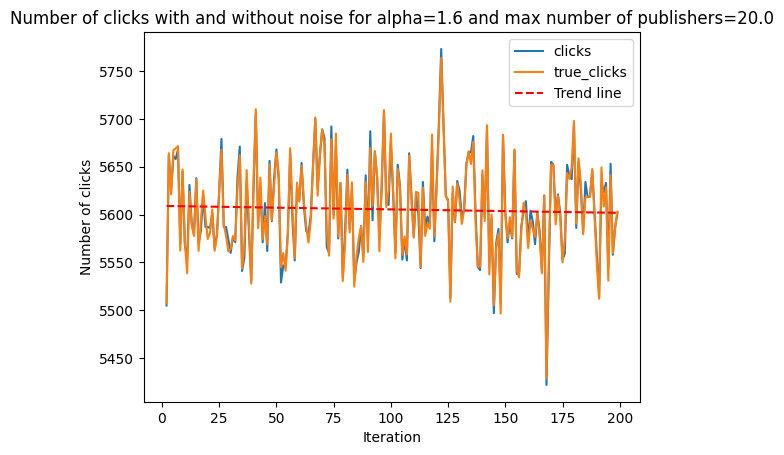

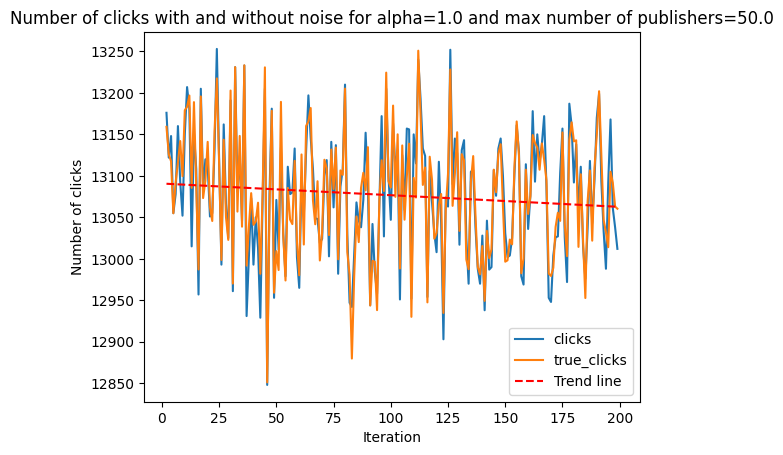

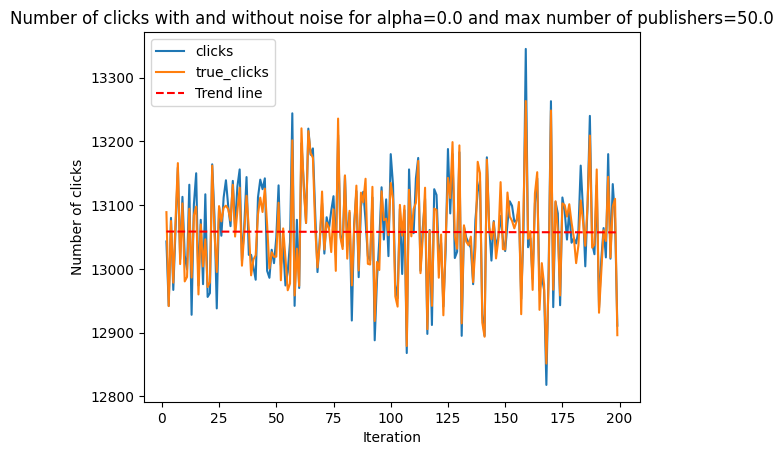

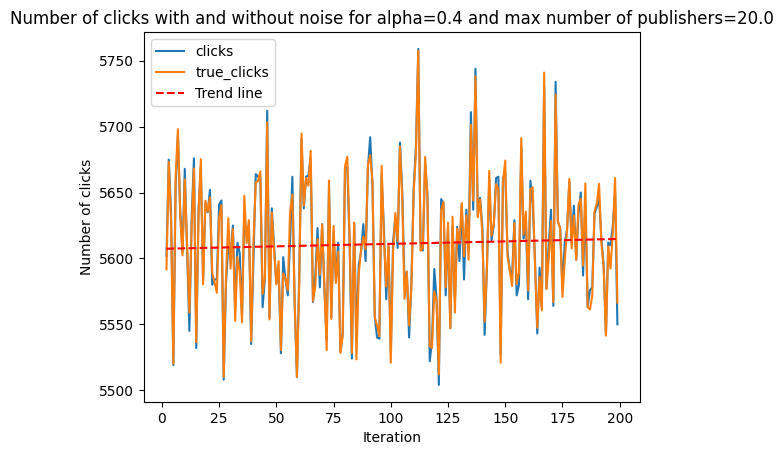

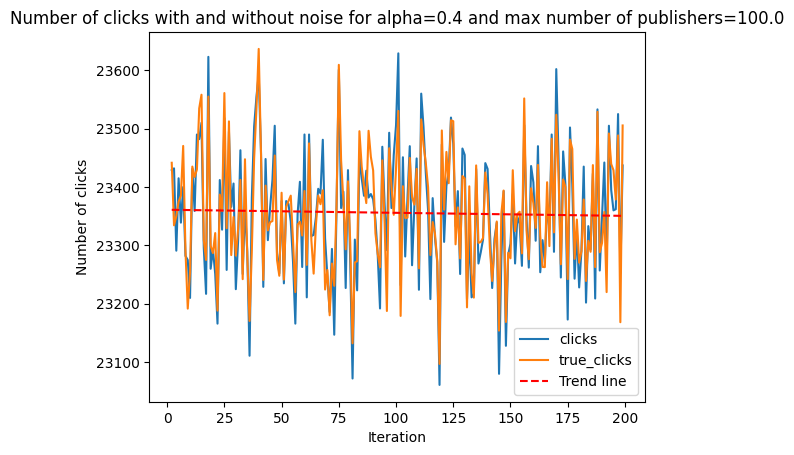

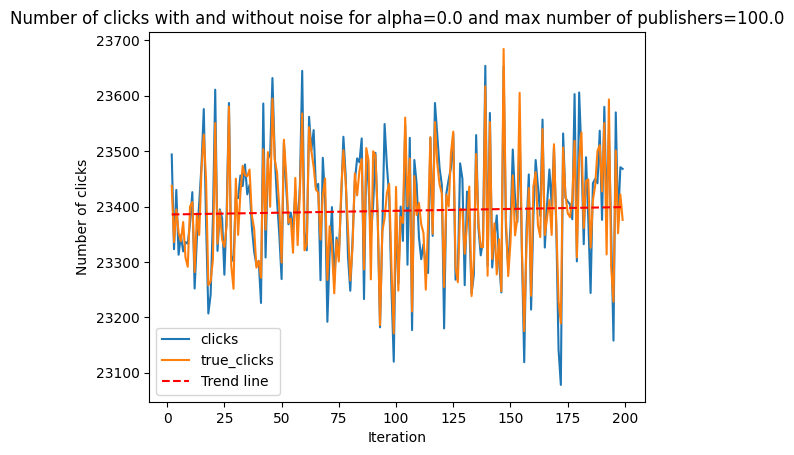

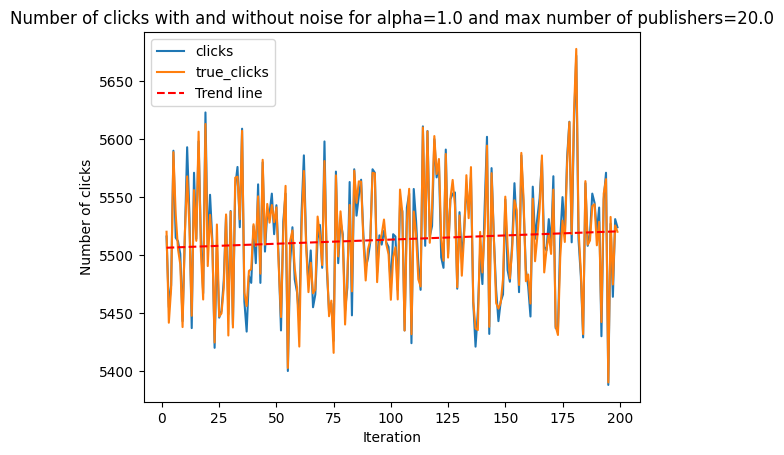

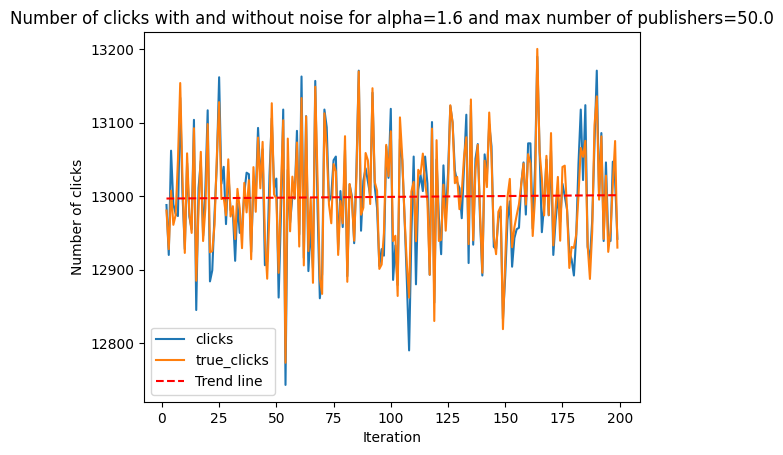

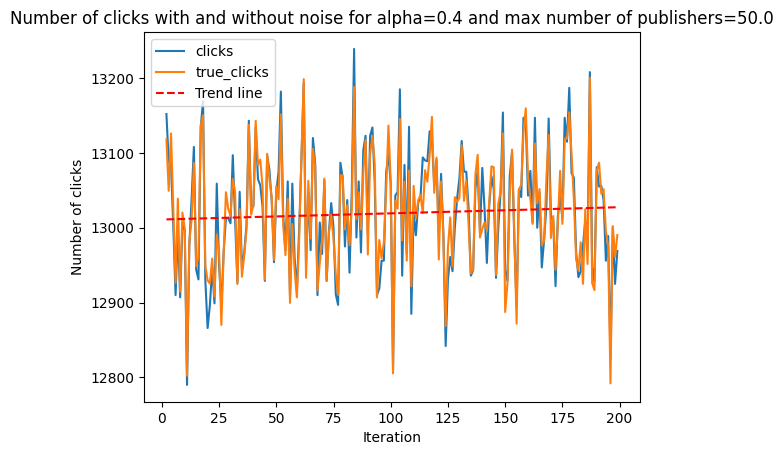

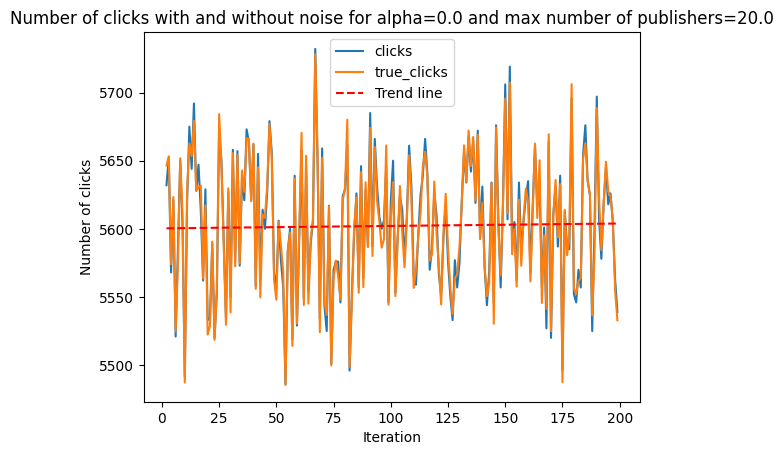

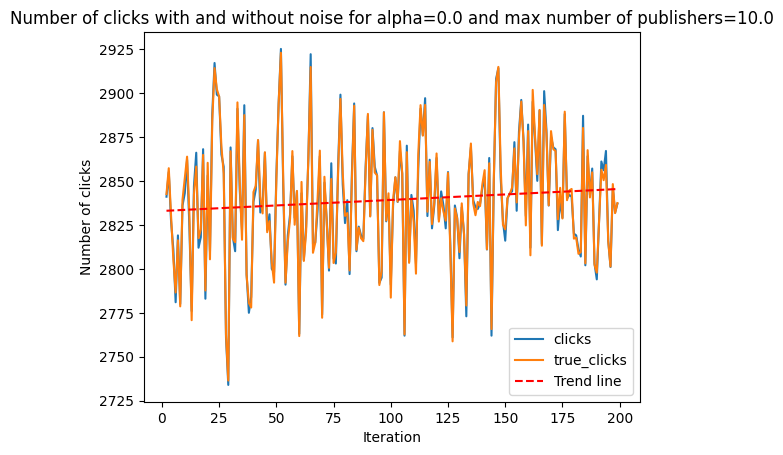

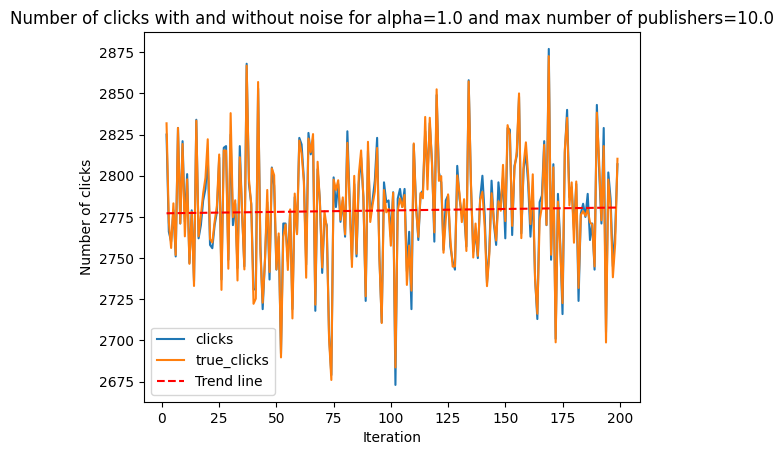

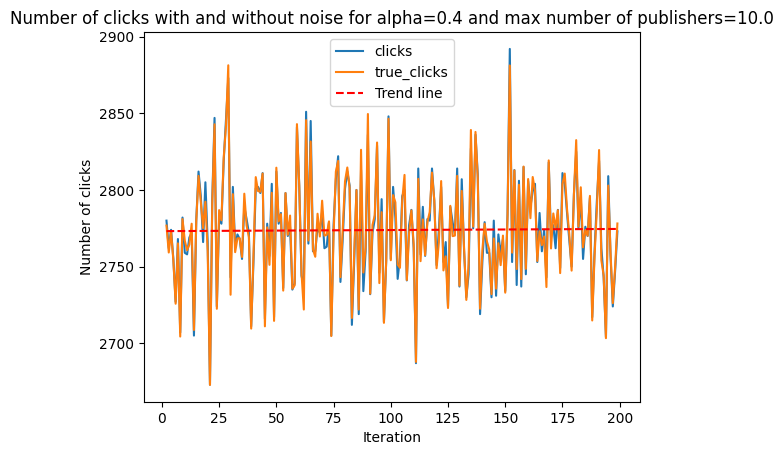

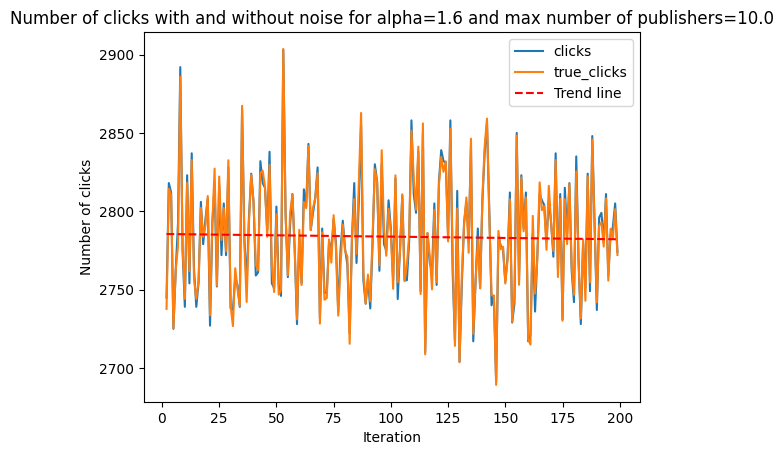

In [17]:
from sklearn.linear_model import LinearRegression
import numpy as np

for (alpha, max_pub), lin_ucb_params in results.items():
    # Filtra i dati
    filtered_data = lin_ucb_params[lin_ucb_params['Iteration'] > 1]
    grouped_data = filtered_data.groupby('Iteration').agg({'clicks': 'sum', 'true_clicks': 'sum'})
    
    # Plotta i dati originali
    grouped_data.plot()
    plt.title(f'Number of clicks with and without noise for alpha={alpha} and max number of publishers={max_pub}')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks')
    
    # Calcola la regressione lineare
    X = grouped_data.index.values.reshape(-1, 1)
    y = grouped_data['true_clicks'].values
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    
    # Aggiungi la retta della regressione al grafico
    plt.plot(grouped_data.index.to_numpy(), y_pred, color='red', linestyle='--', label='Trend line')
    plt.legend()
    plt.show()

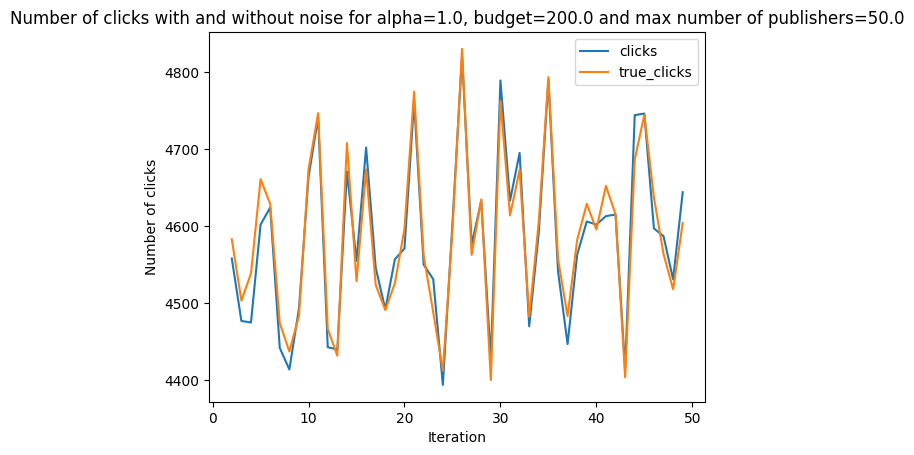

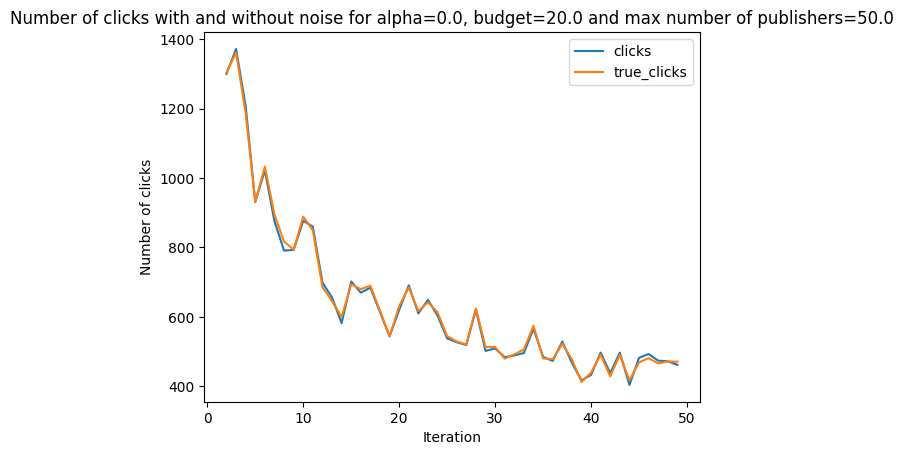

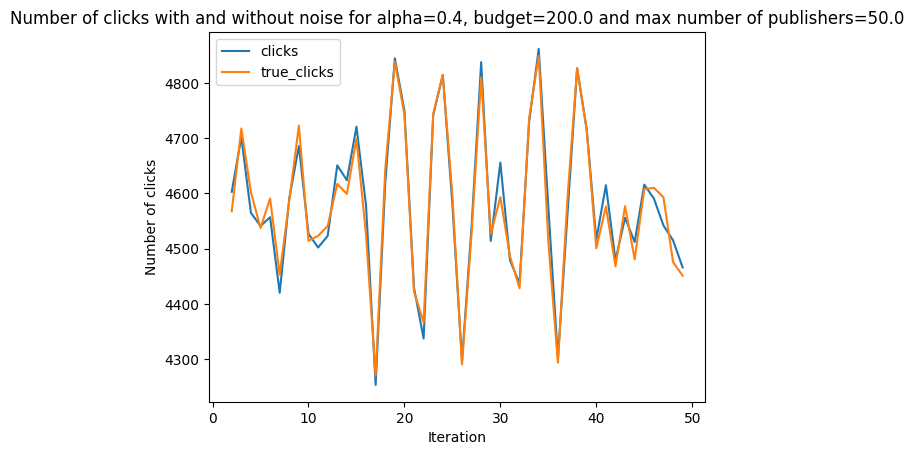

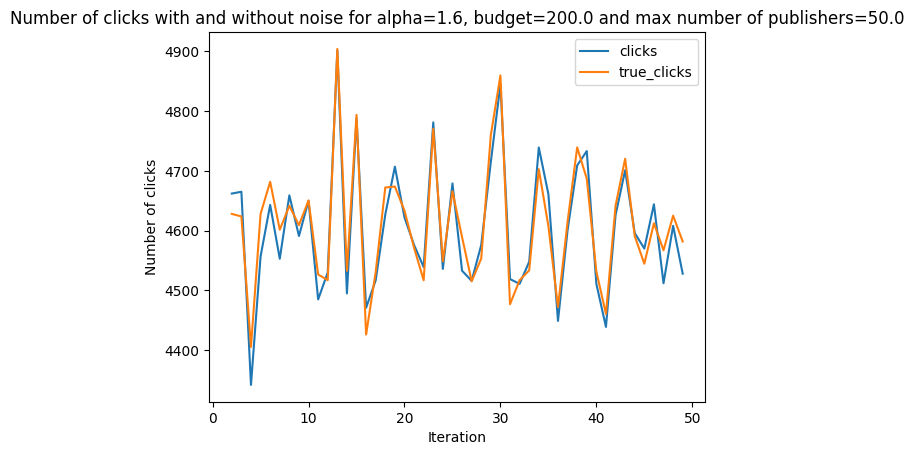

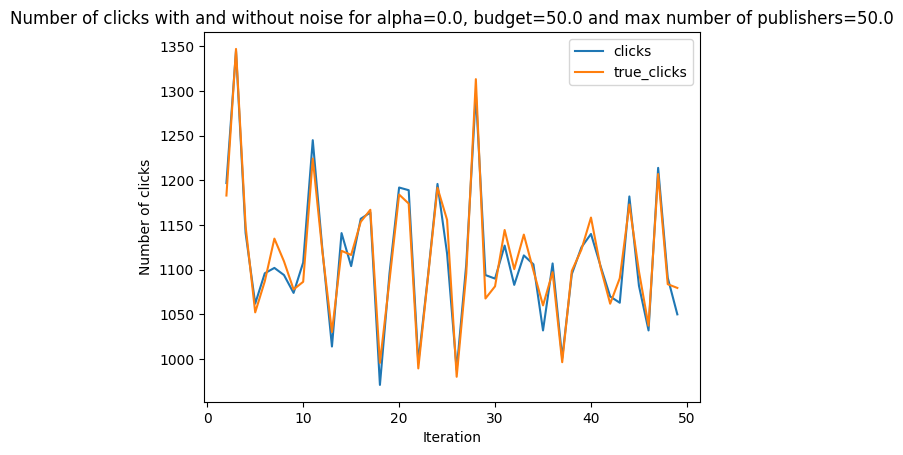

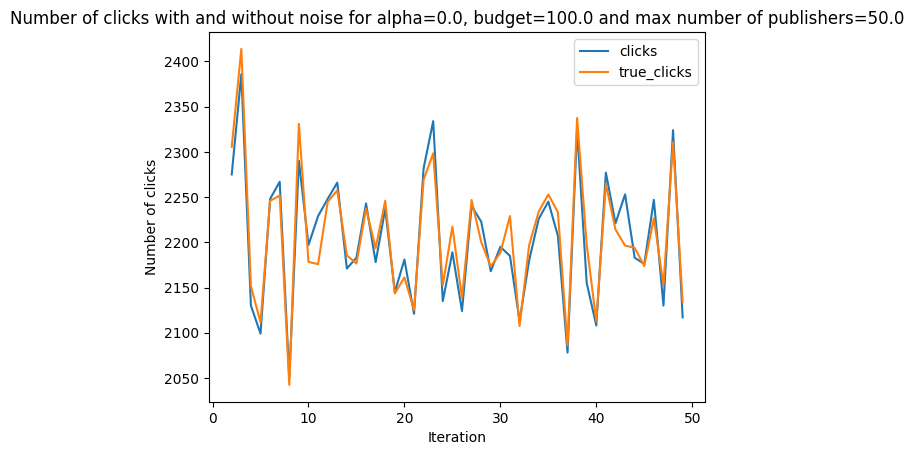

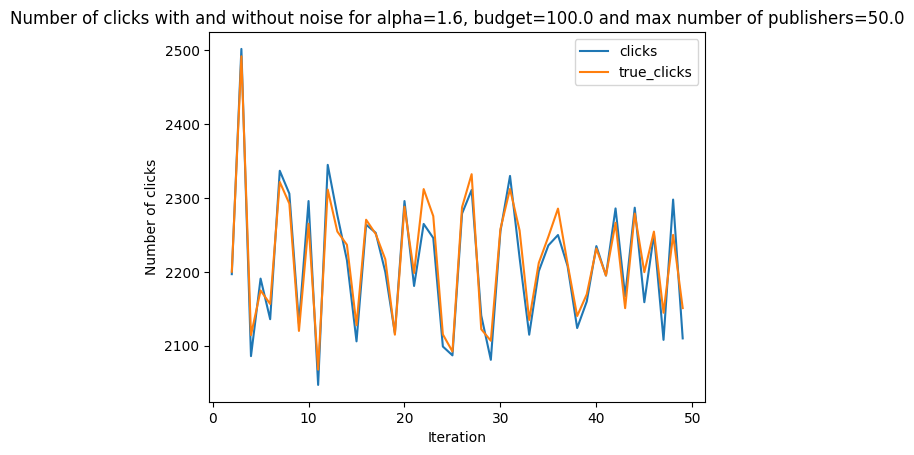

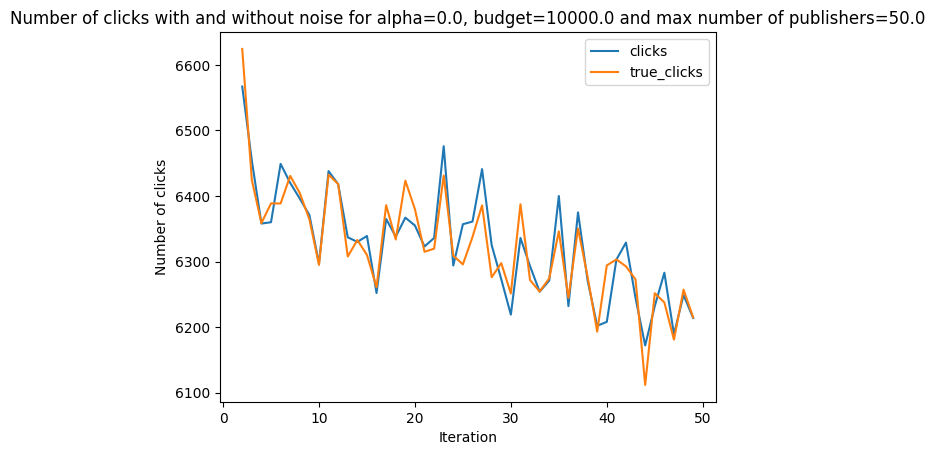

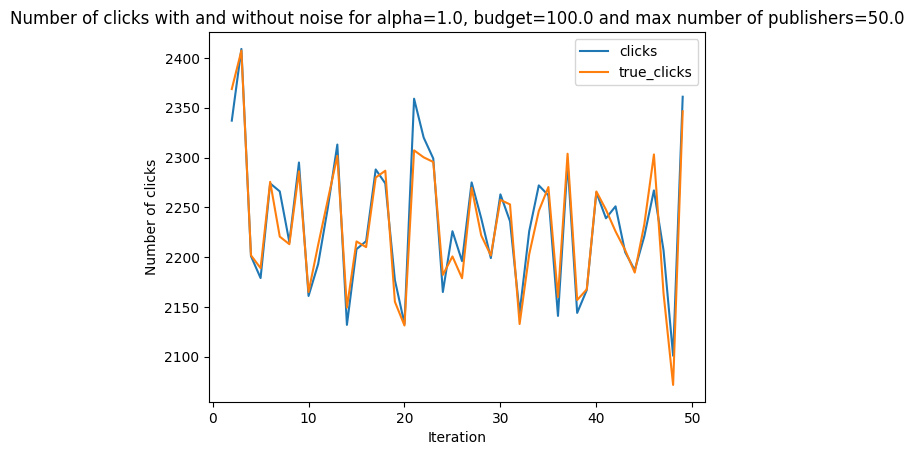

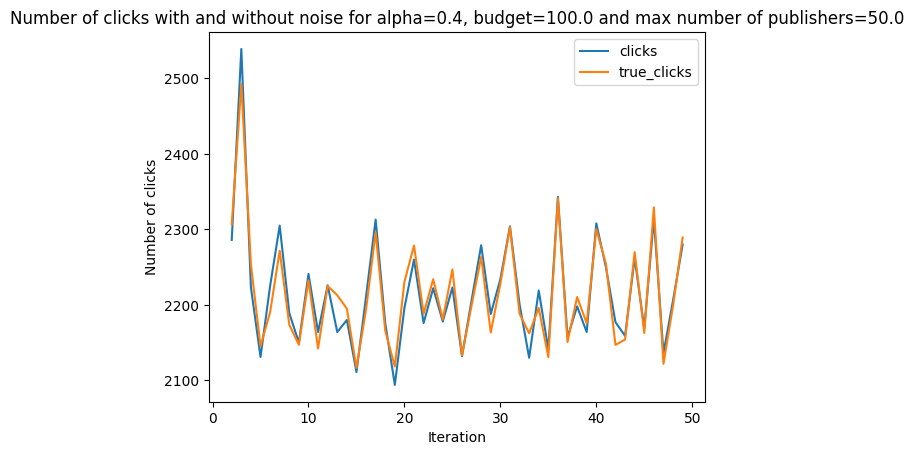

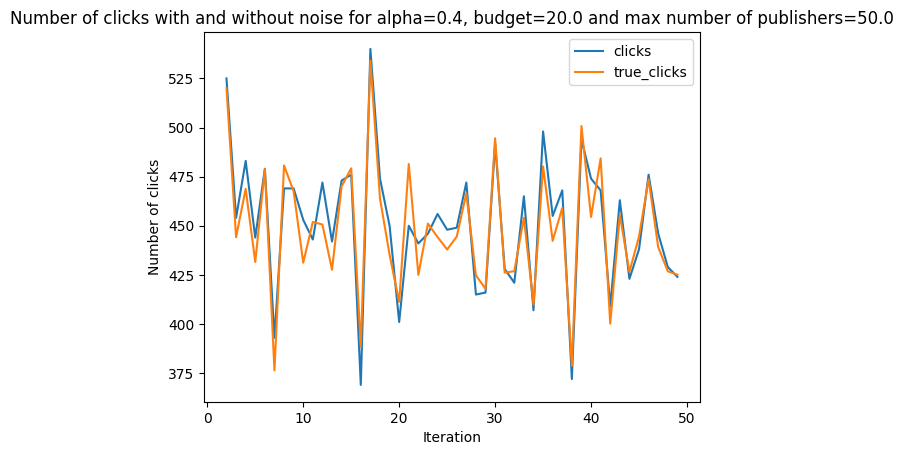

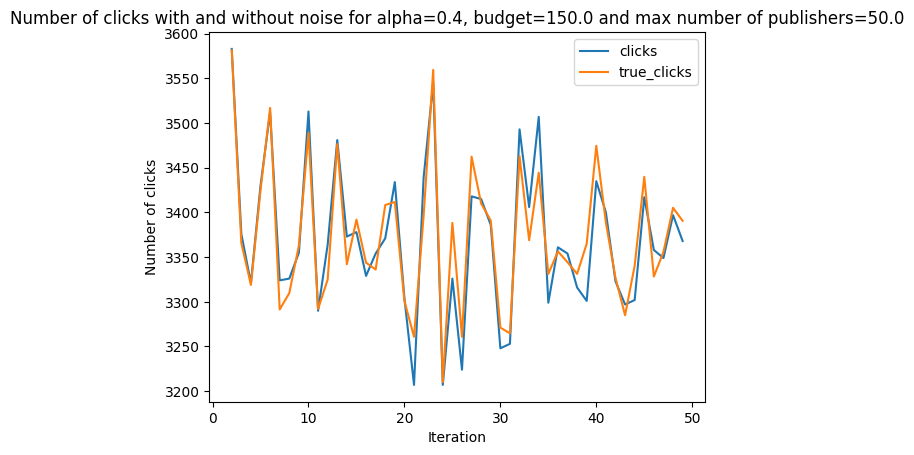

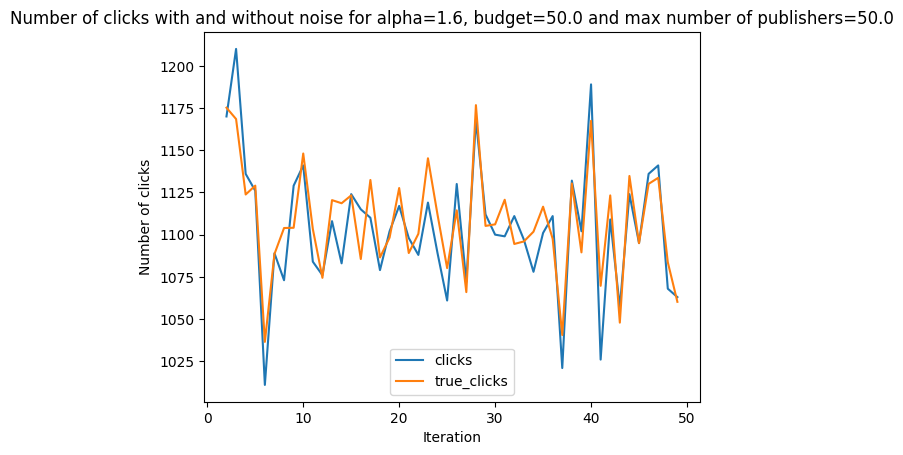

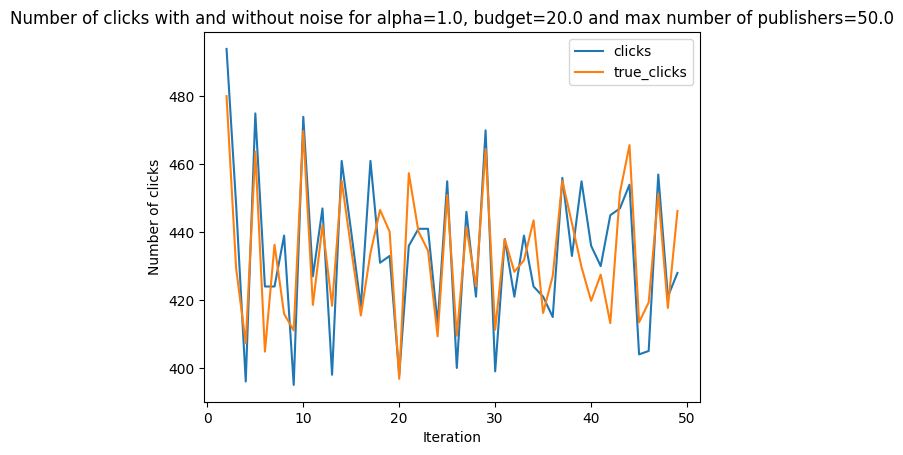

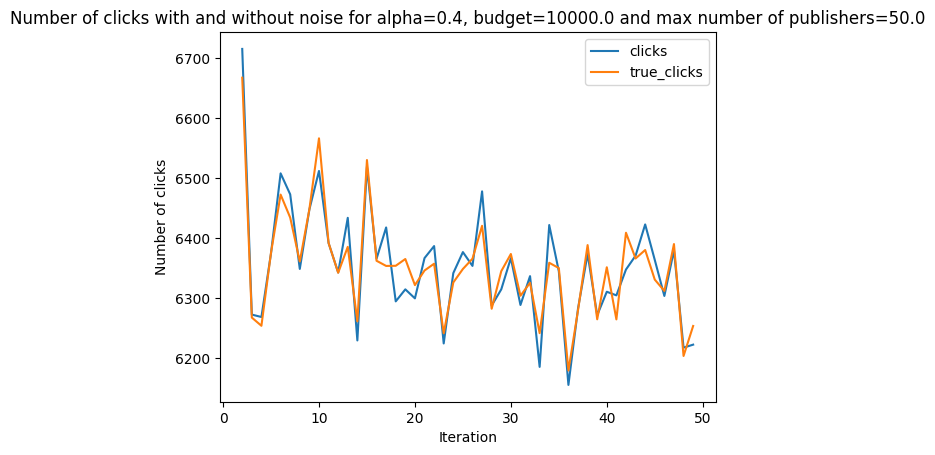

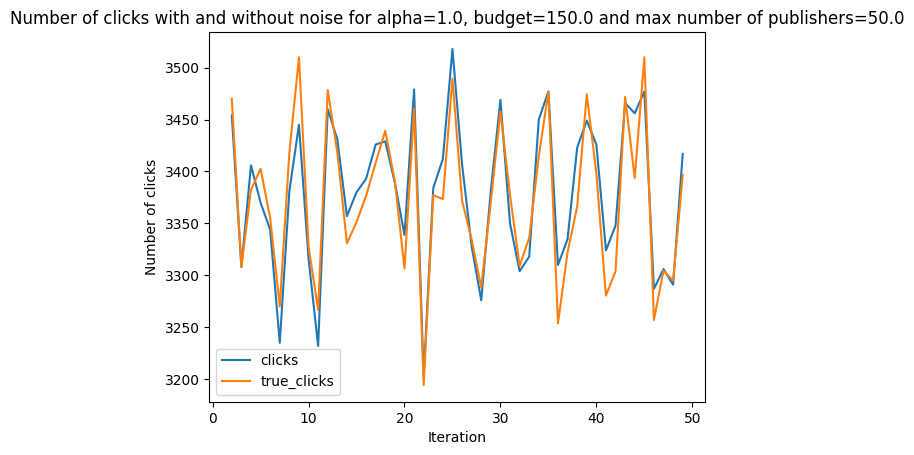

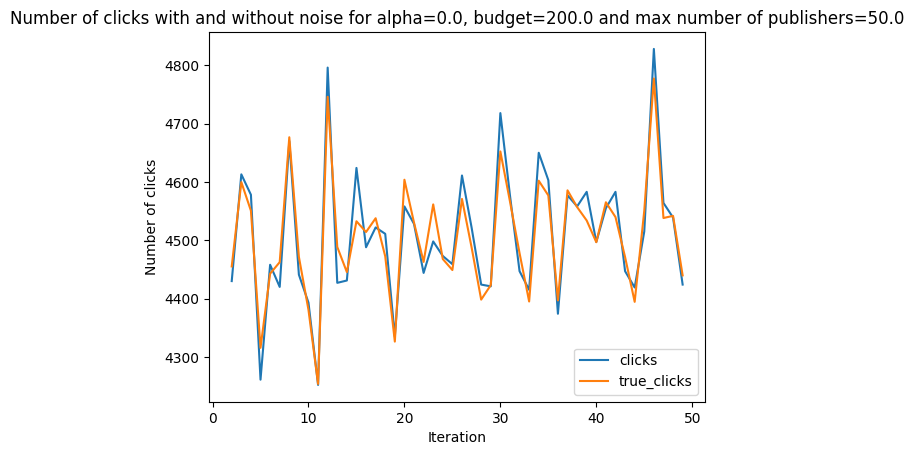

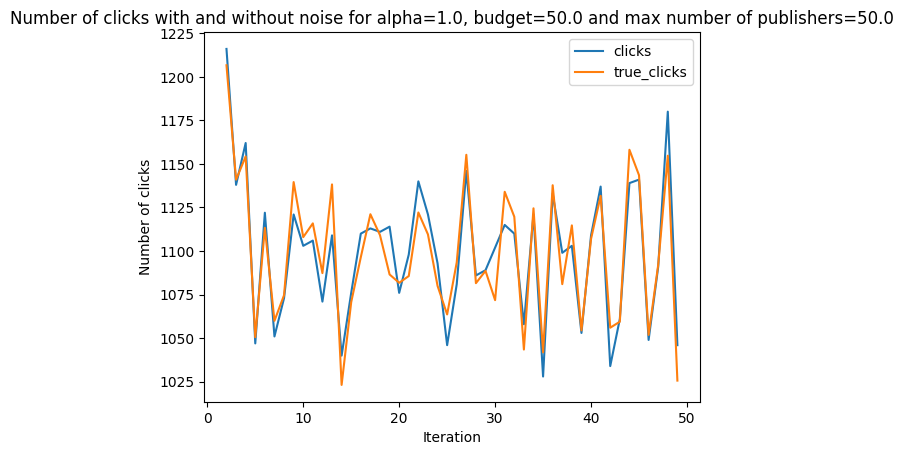

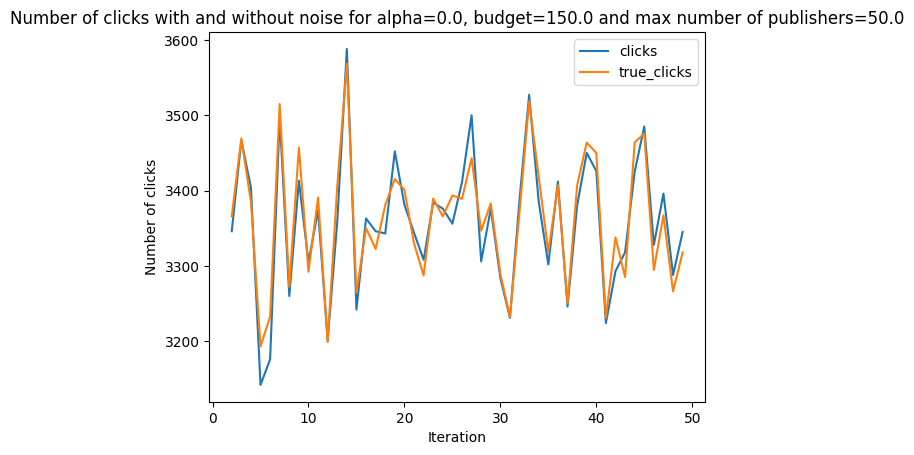

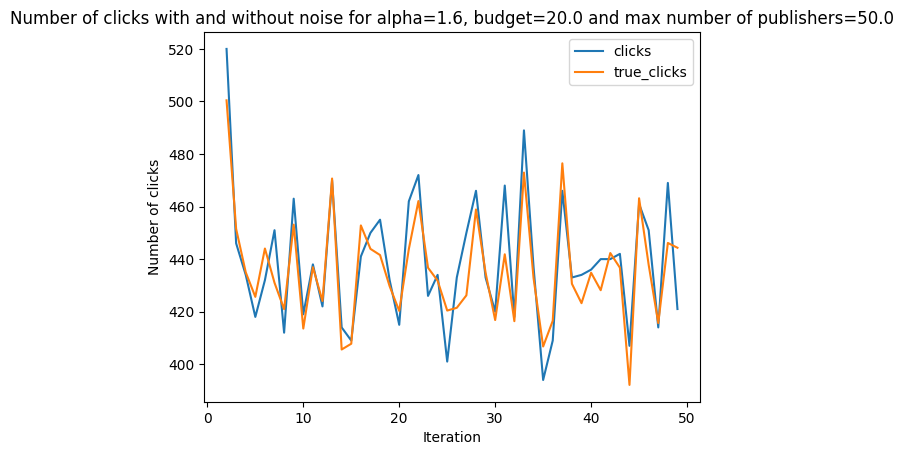

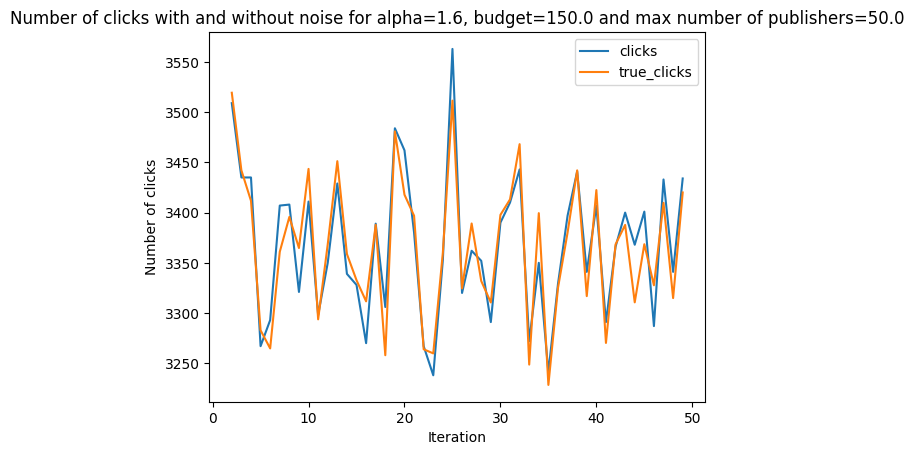

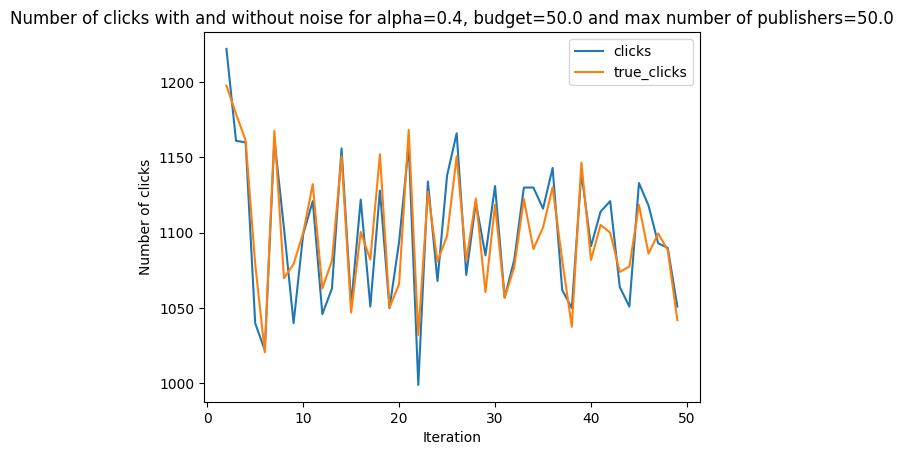

In [26]:
# Plot number of clicks with and without noise for each alpha, budget and max number of publishers
for (budget, alpha, max_pub), lin_ucb_params in results.items():
    lin_ucb_params[(lin_ucb_params['Iteration'] > 1)].groupby('Iteration').agg({'clicks': 'sum', 'true_clicks': 'sum'}).plot()
    plt.title(f'Number of clicks with and without noise for alpha={alpha}, budget={budget} and max number of publishers={max_pub}')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks')
    plt.show()

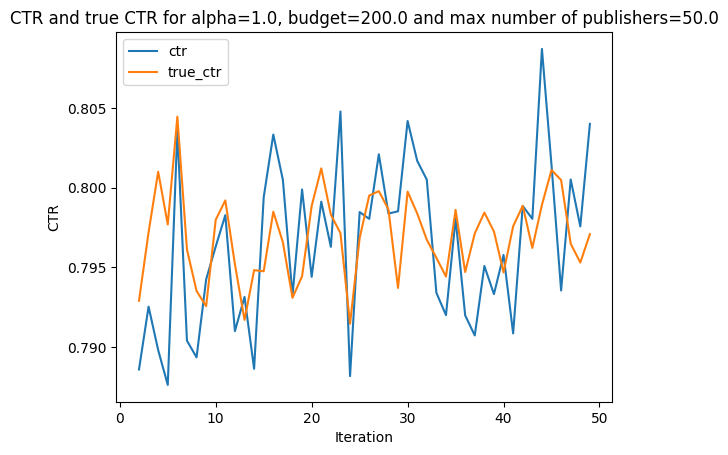

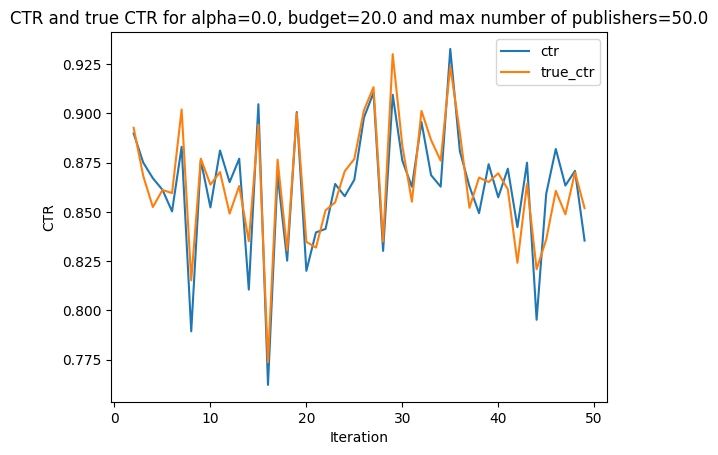

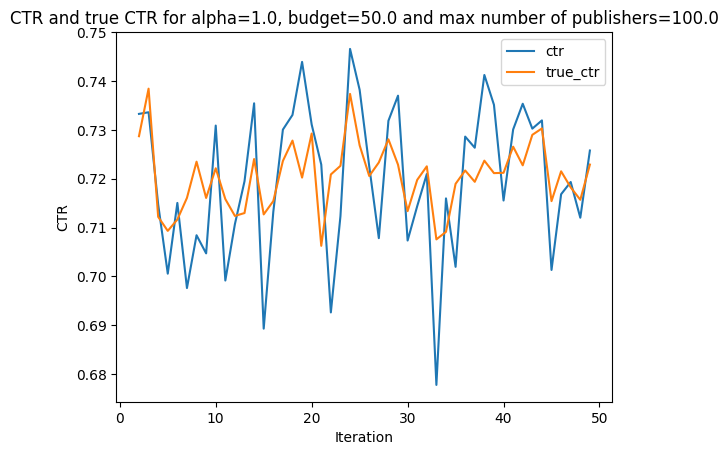

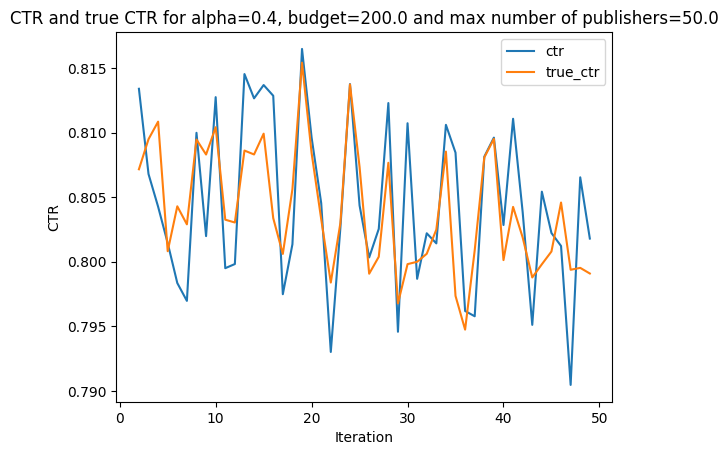

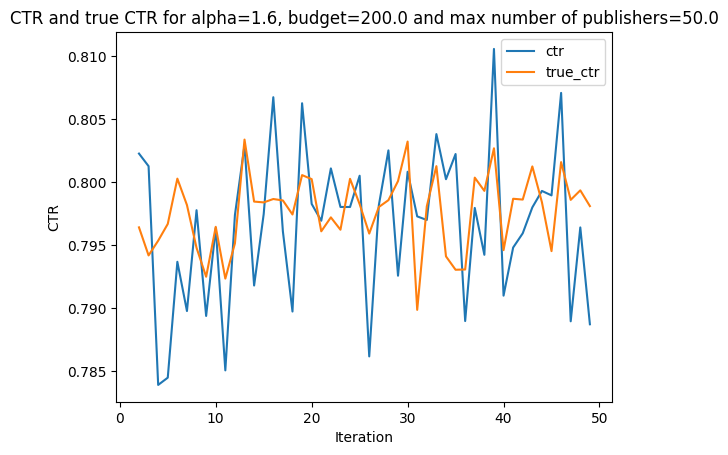

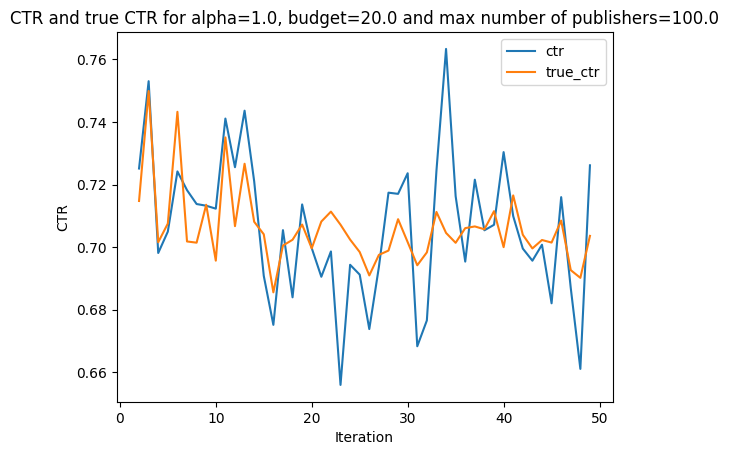

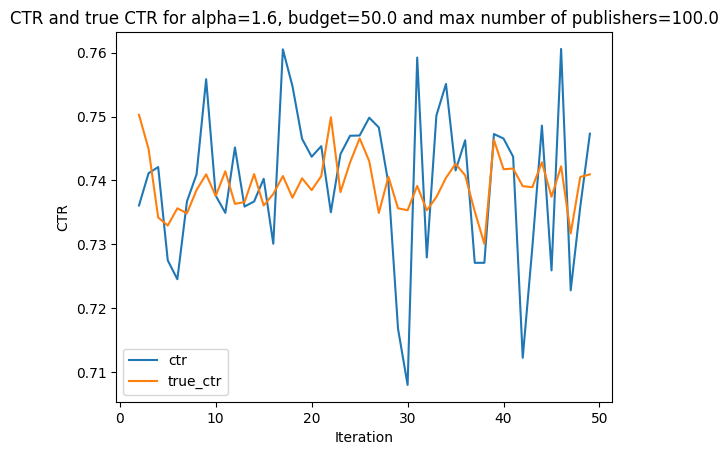

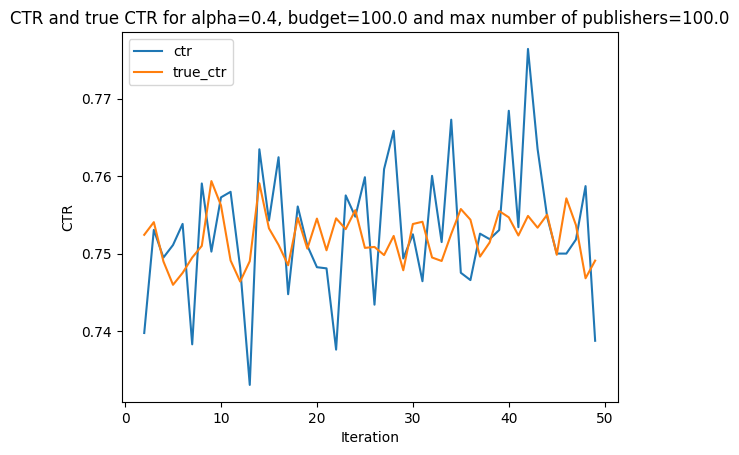

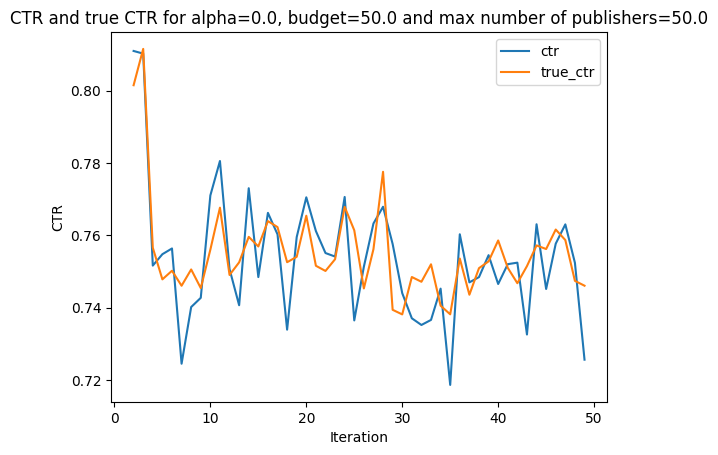

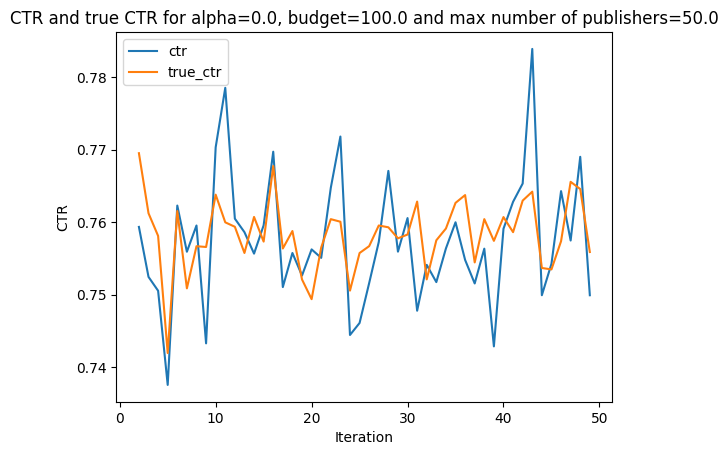

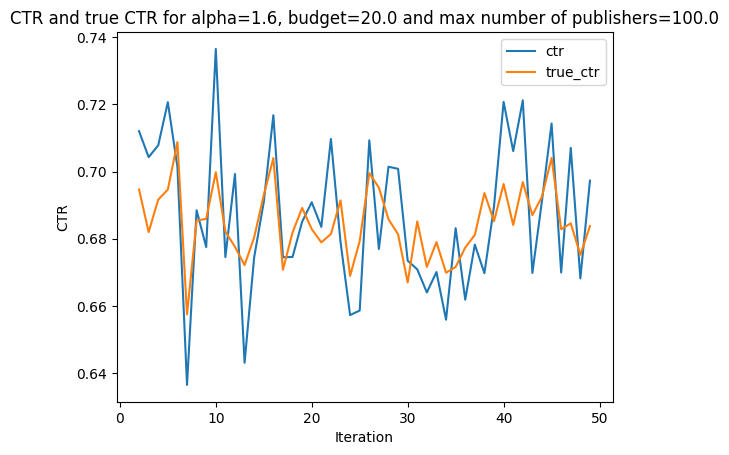

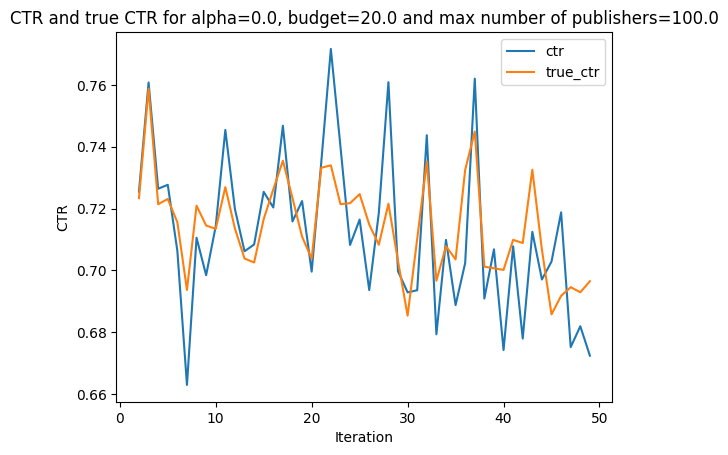

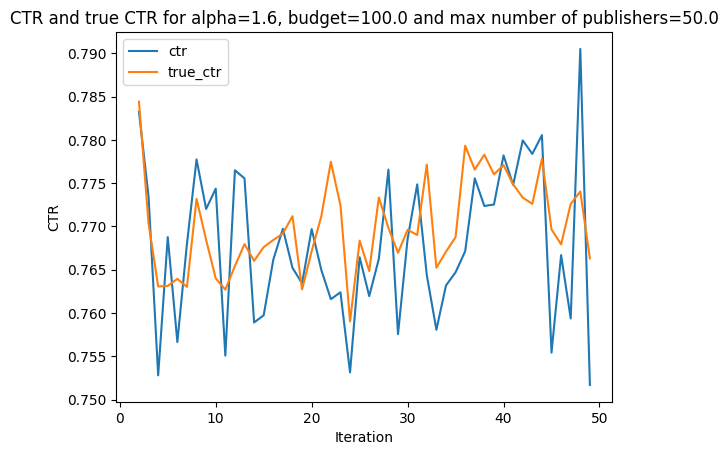

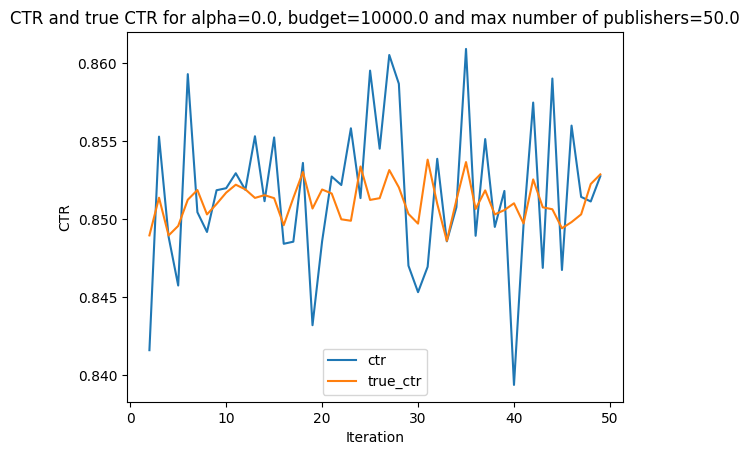

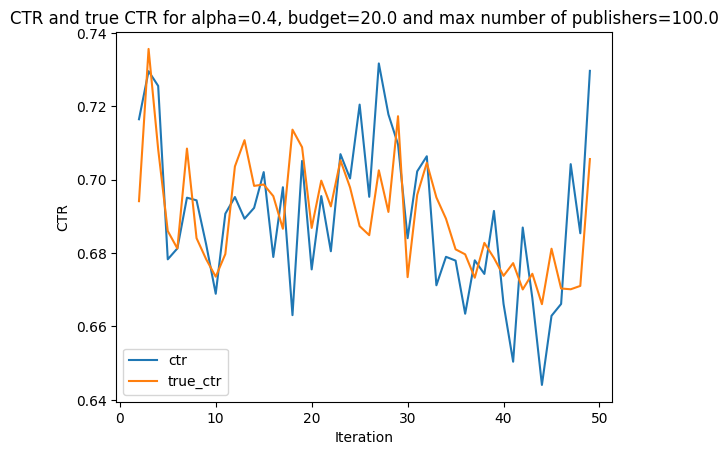

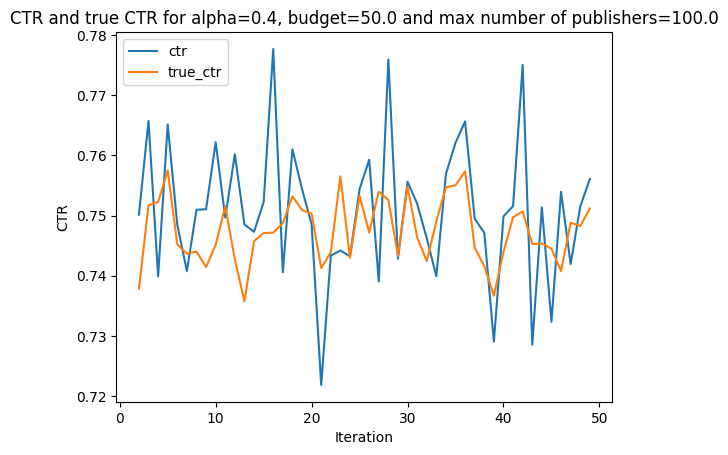

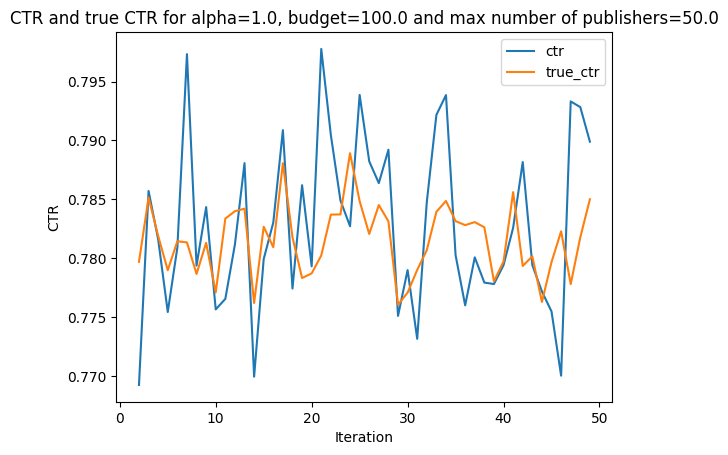

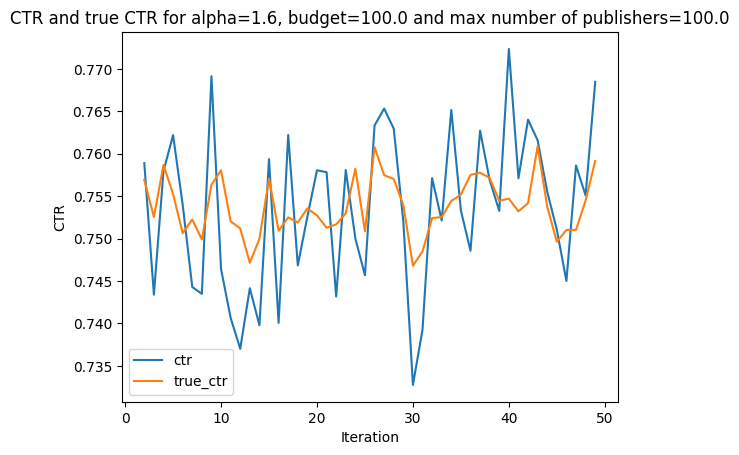

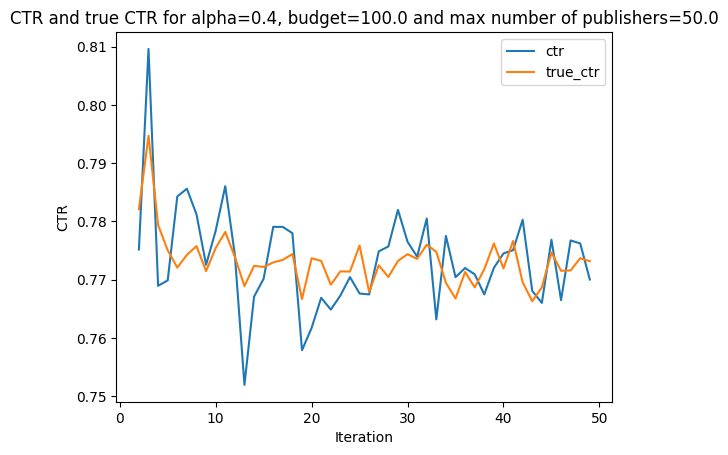

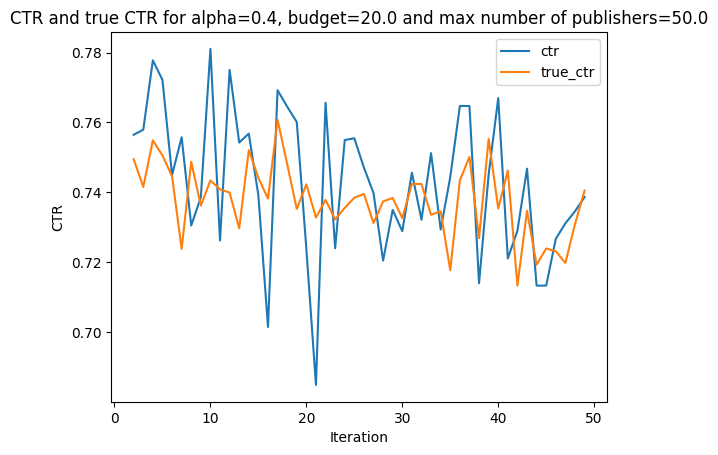

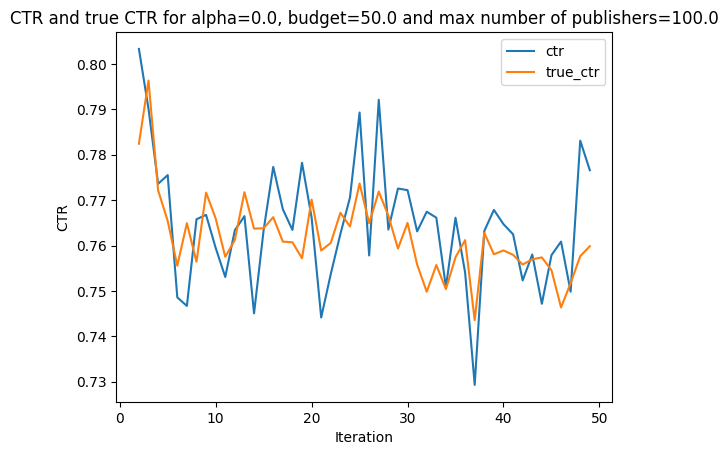

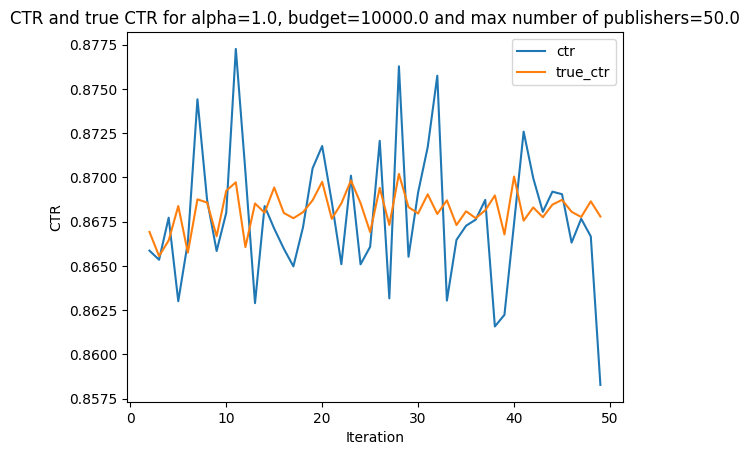

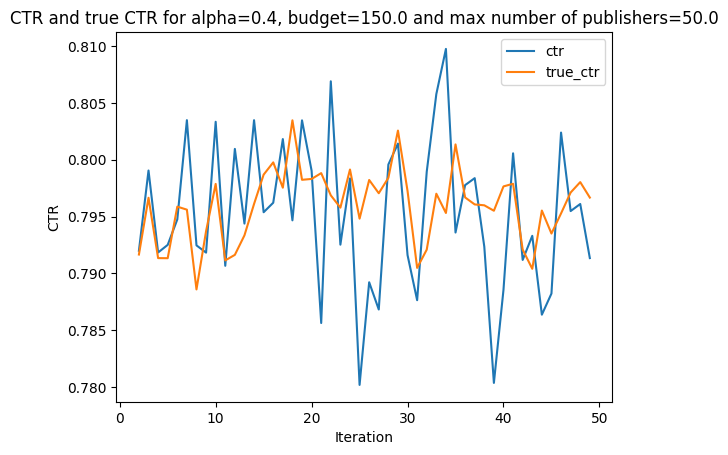

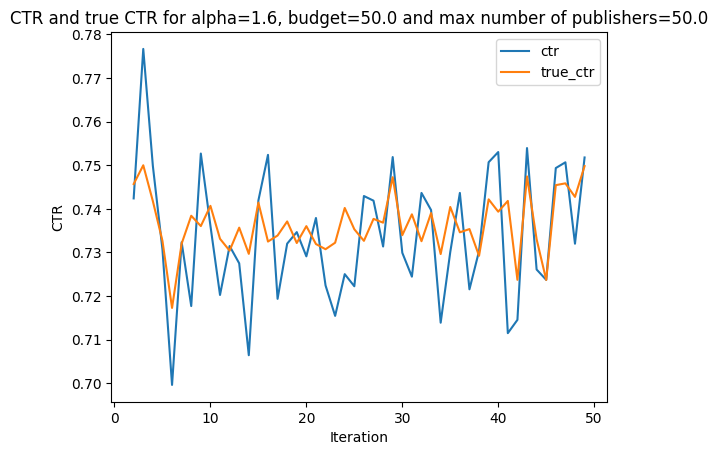

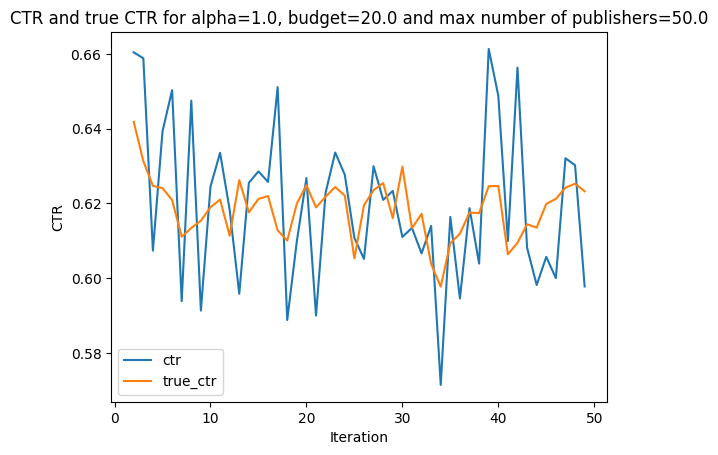

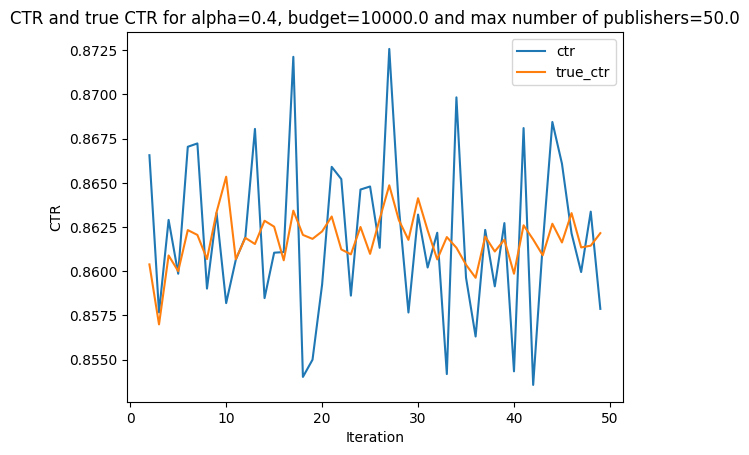

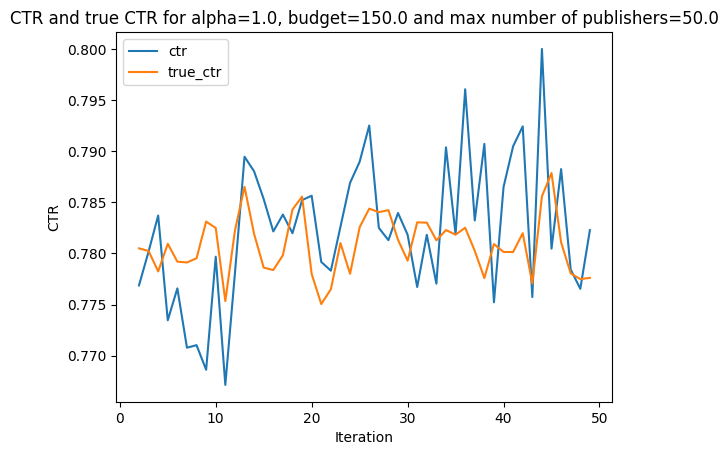

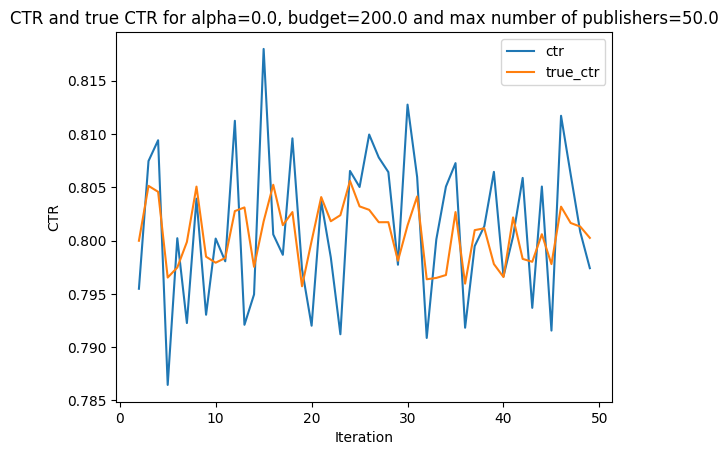

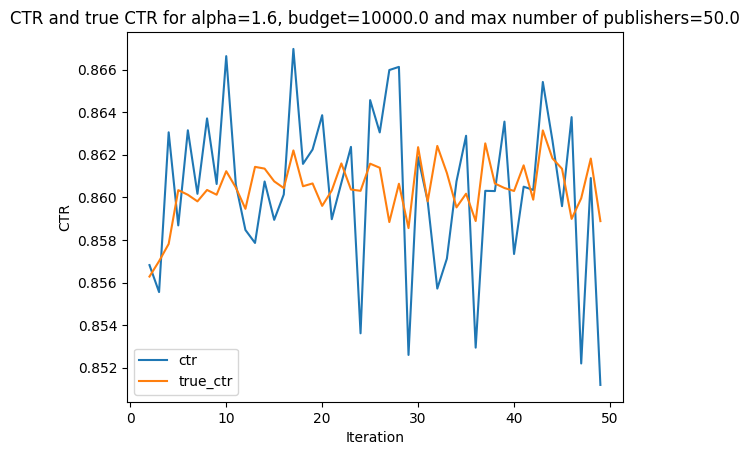

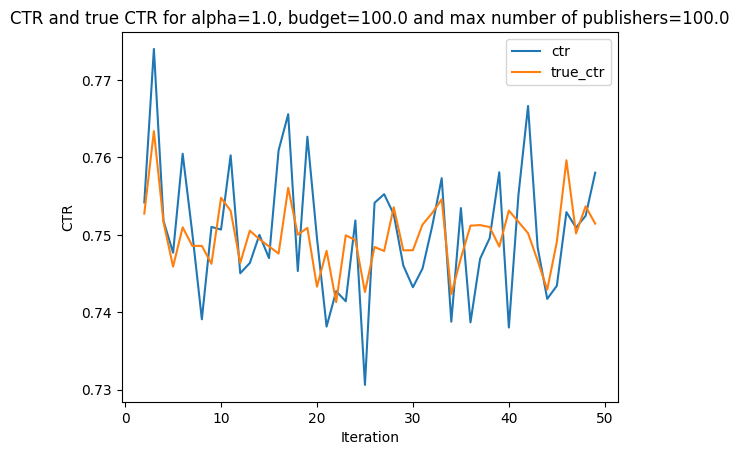

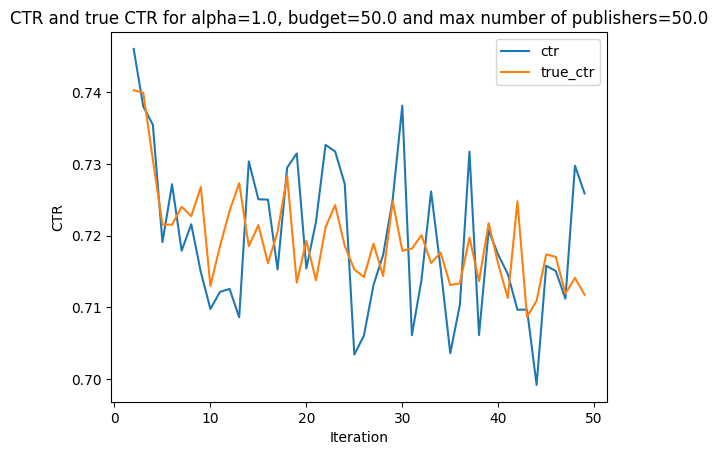

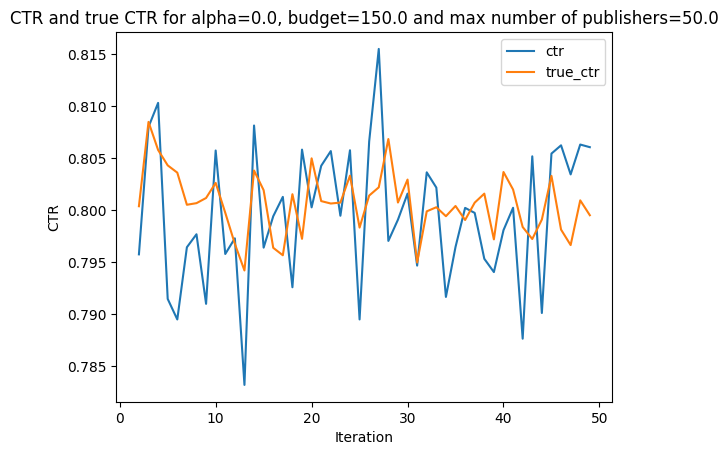

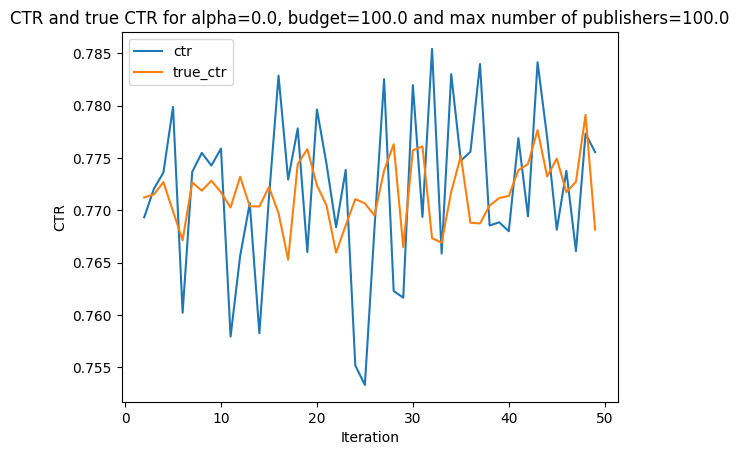

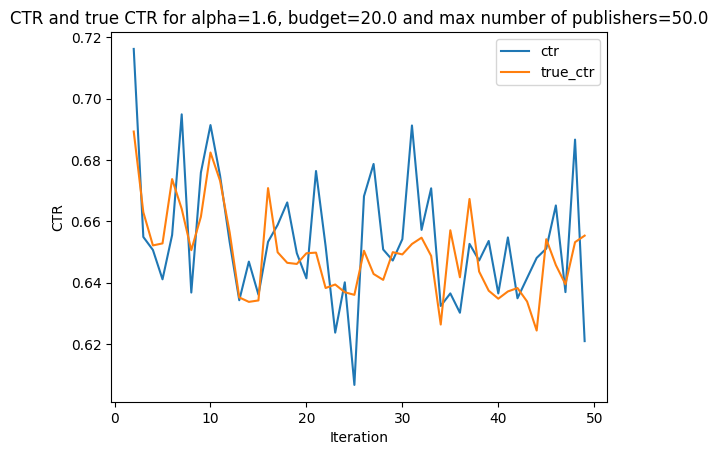

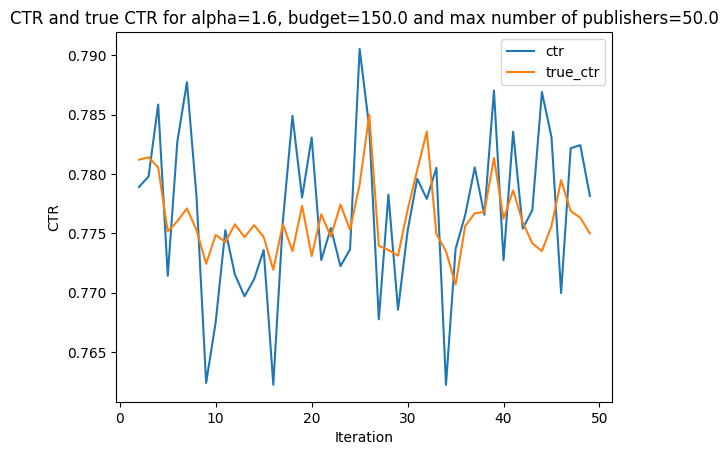

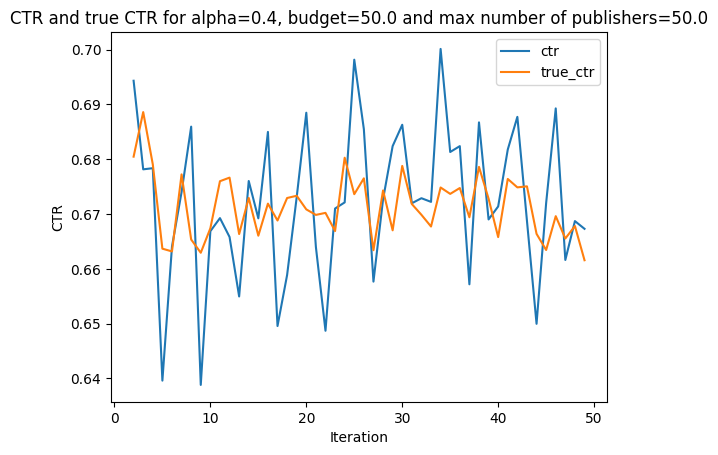

In [31]:
# Plot ctr and true ctr for each alpha, budget and max number of publishers
for (budget, alpha, max_pub), lin_ucb_params in results.items():
    iter_gt_1 = lin_ucb_params[lin_ucb_params['Iteration'] > 1]
    group_data = iter_gt_1.groupby('Iteration').agg({'impressions': 'sum','clicks': 'sum', 'true_clicks': 'sum'})
    group_data['ctr'] = group_data['clicks'] / group_data['impressions']
    group_data['true_ctr'] = group_data['true_clicks'] / group_data['impressions']
    group_data[['ctr', 'true_ctr']].plot()
    plt.title(f'CTR and true CTR for alpha={alpha}, budget={budget} and max number of publishers={max_pub}')
    plt.xlabel('Iteration')
    plt.ylabel('CTR')
    plt.show()

# Plot percentage of publishers that generates 0 clicks for each alpha, keeping budget and max number of publishers fixed

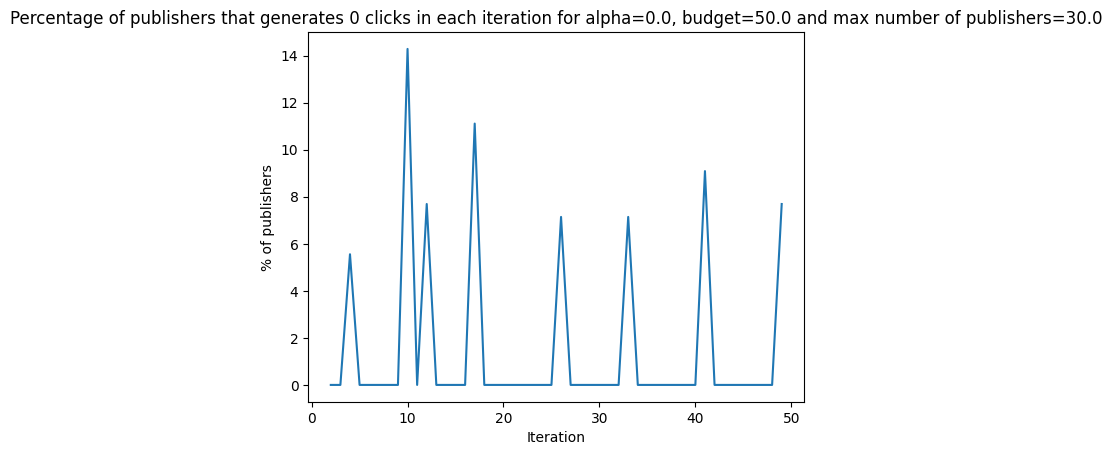

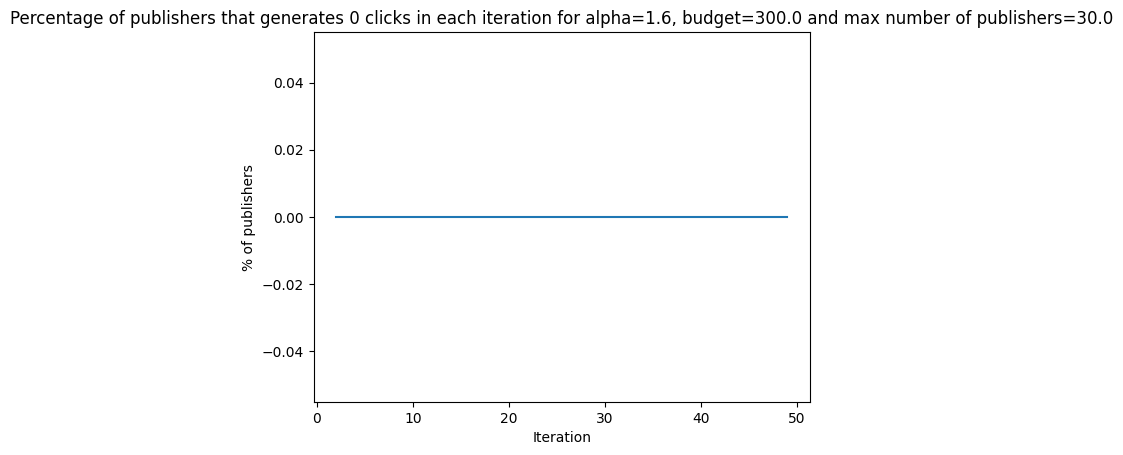

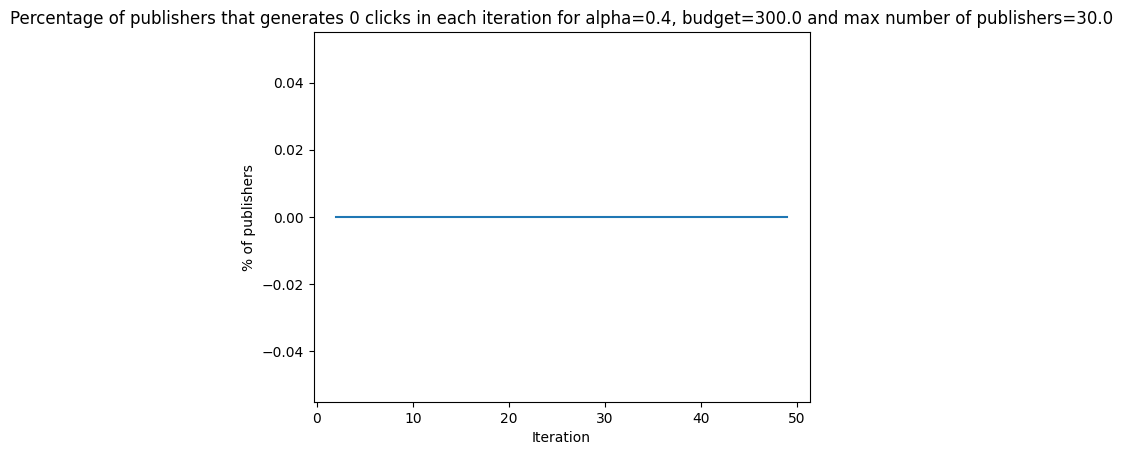

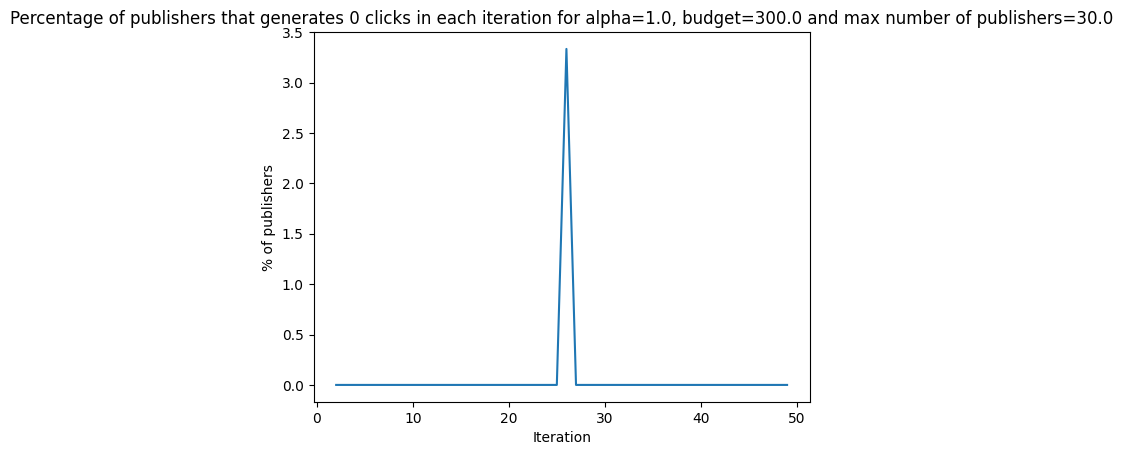

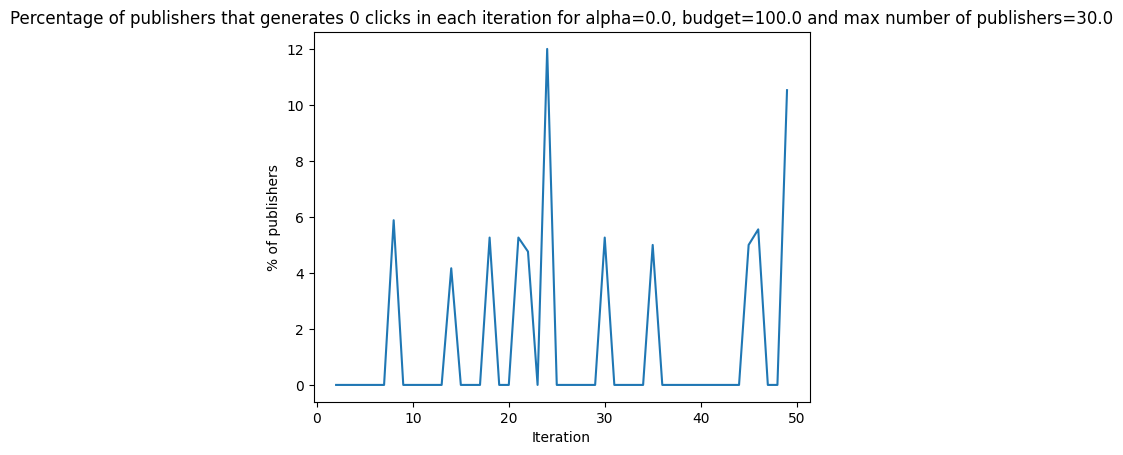

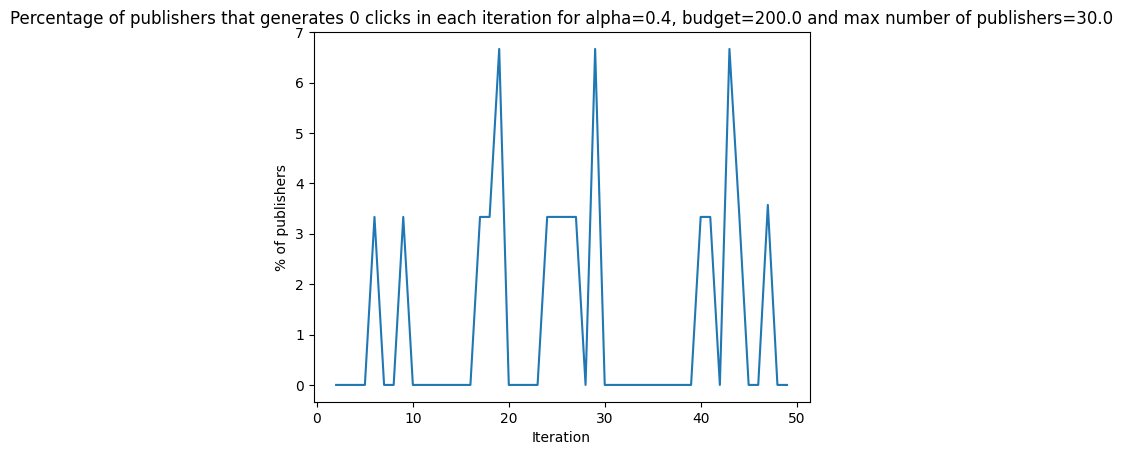

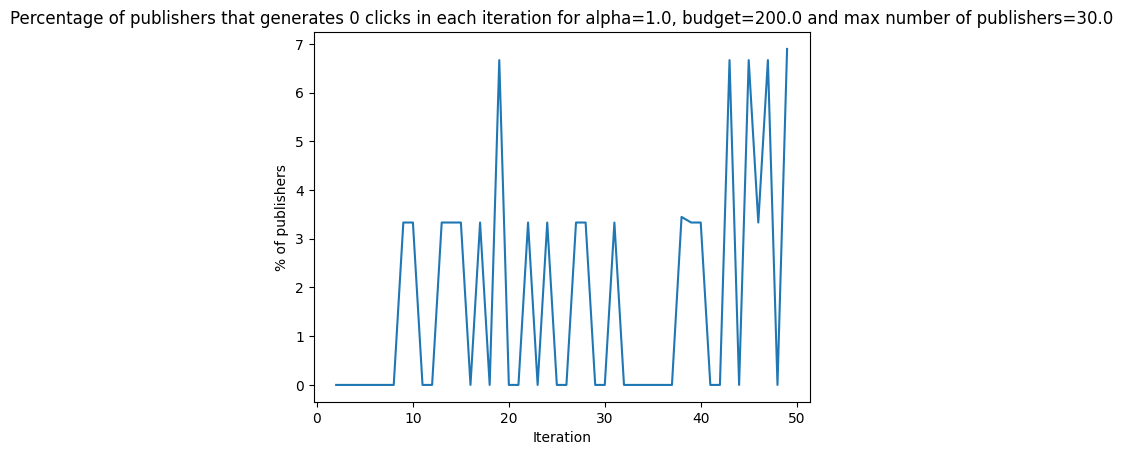

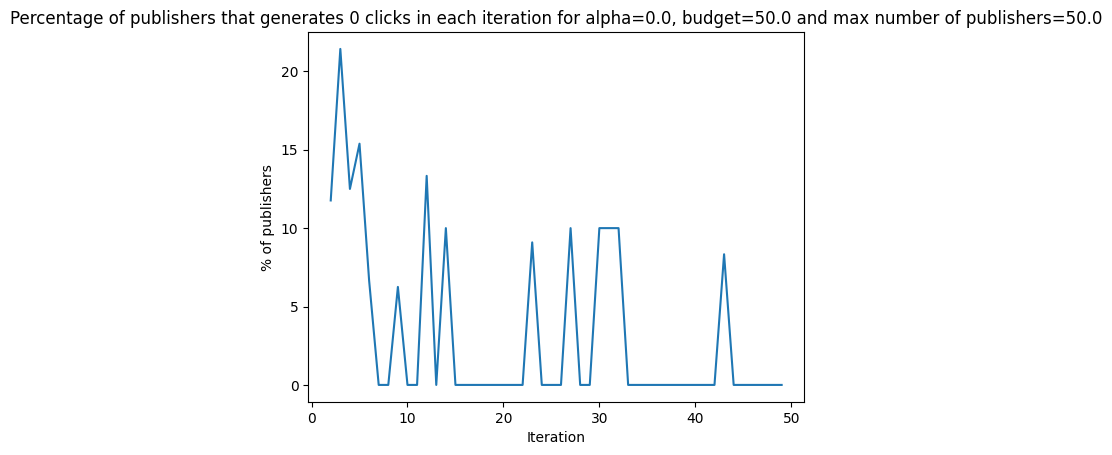

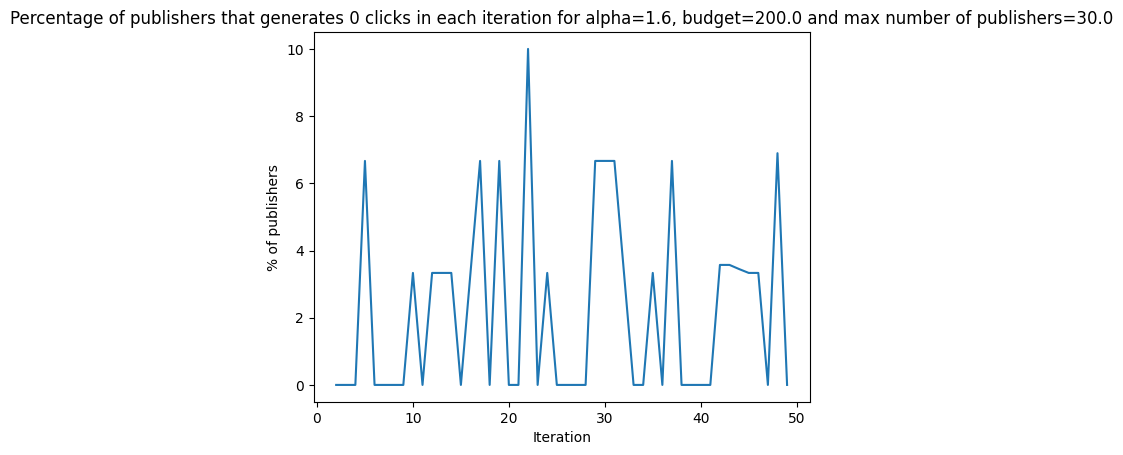

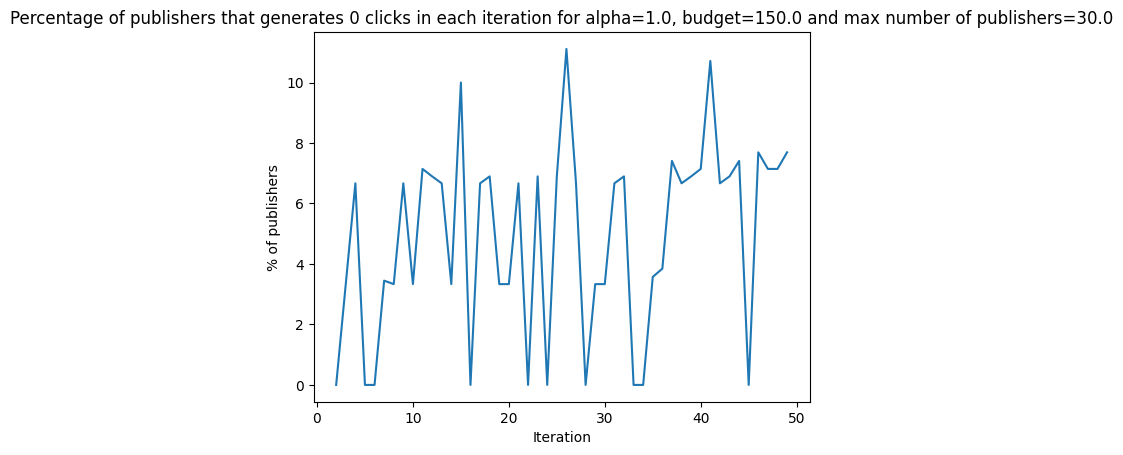

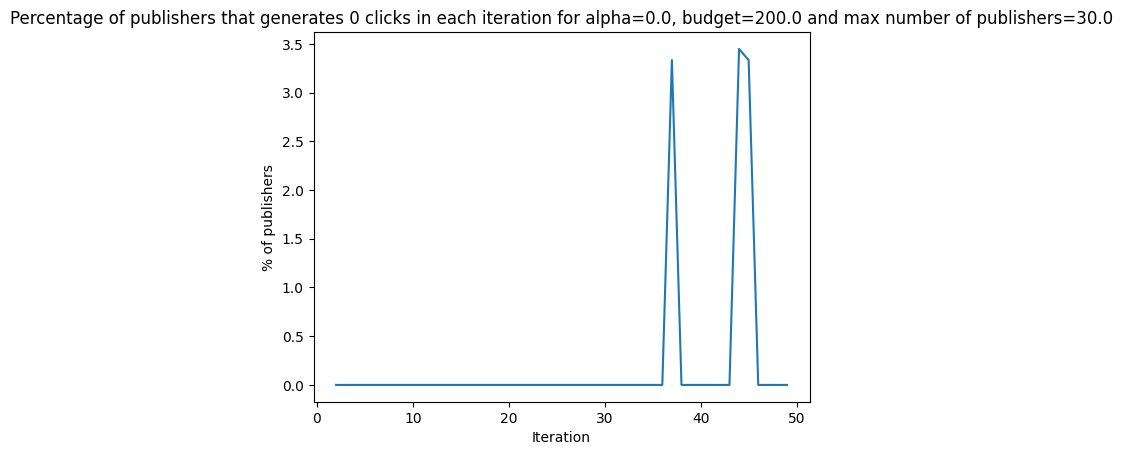

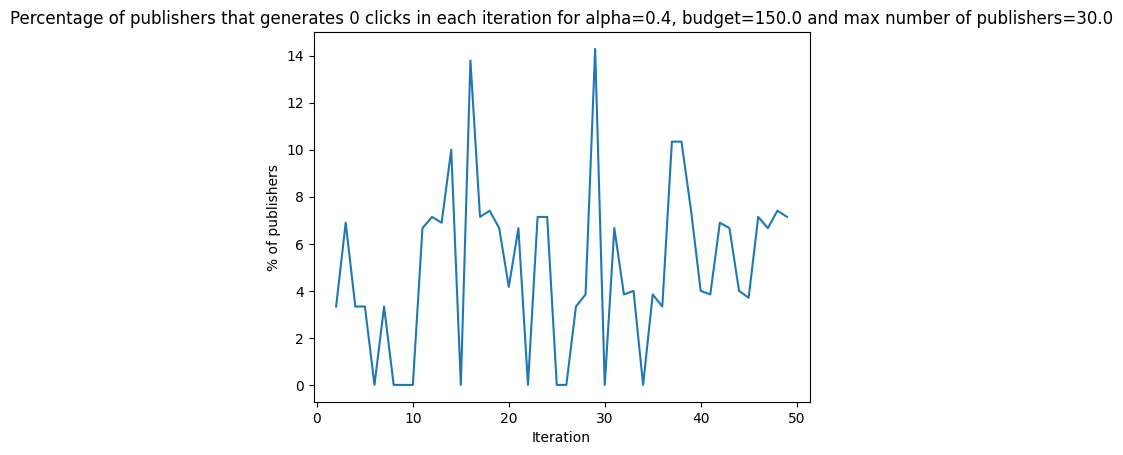

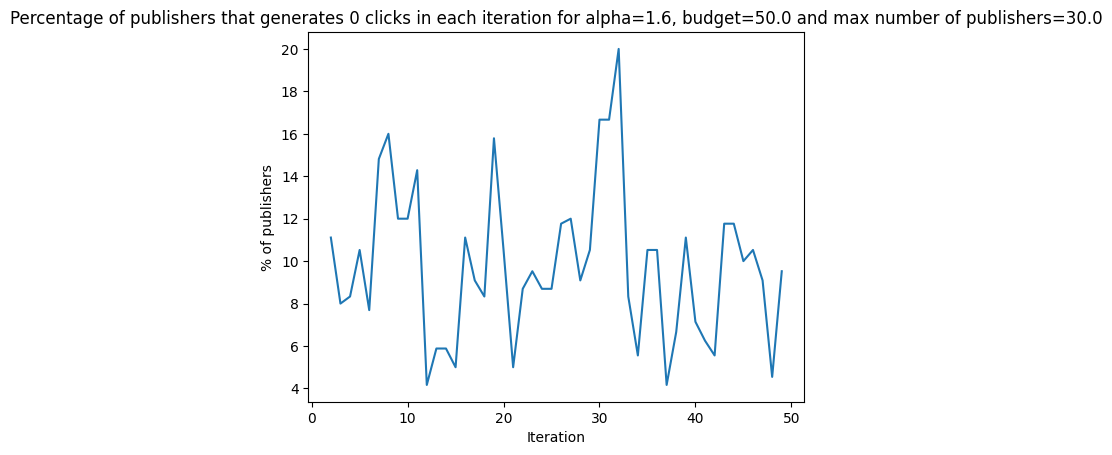

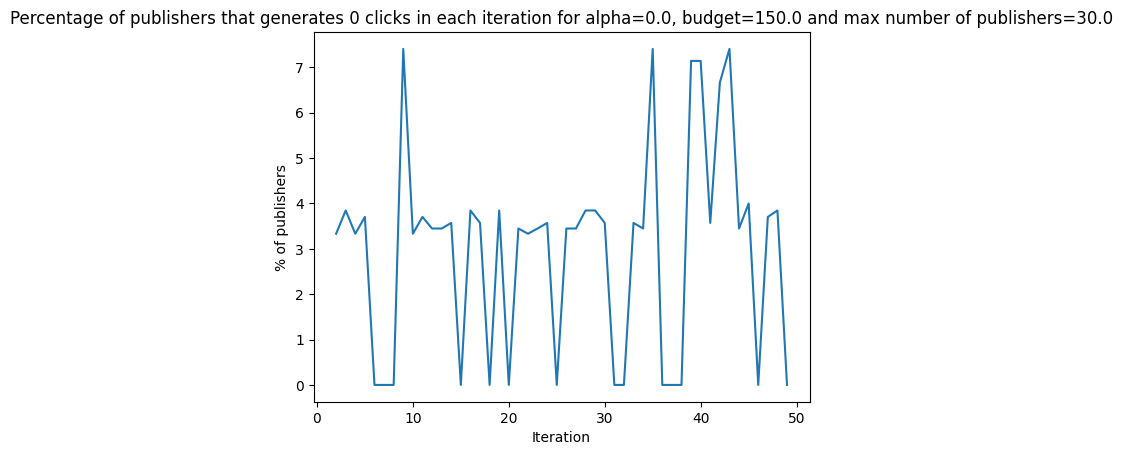

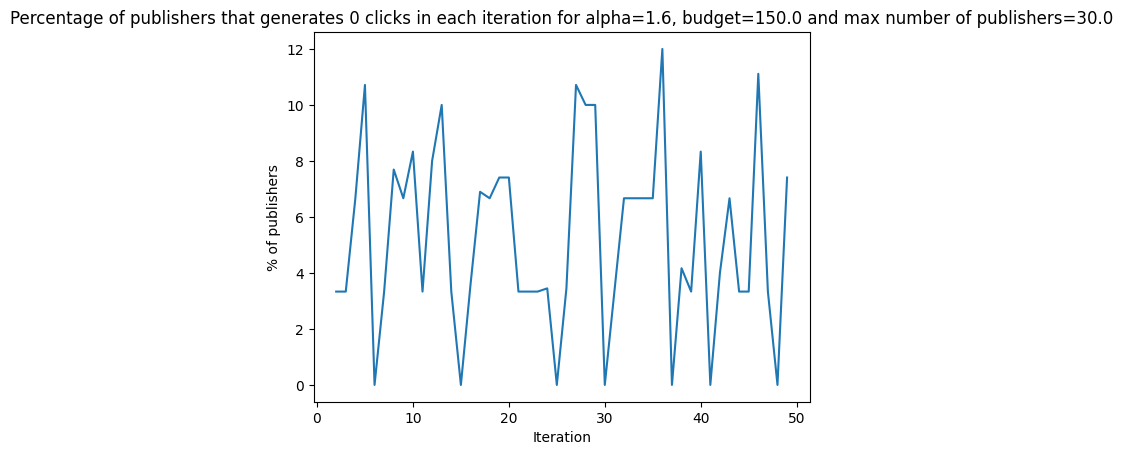

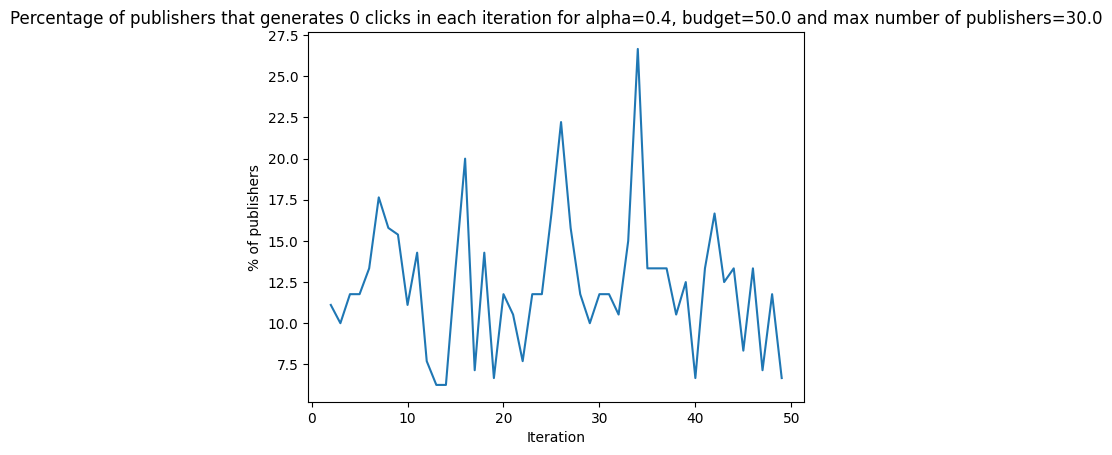

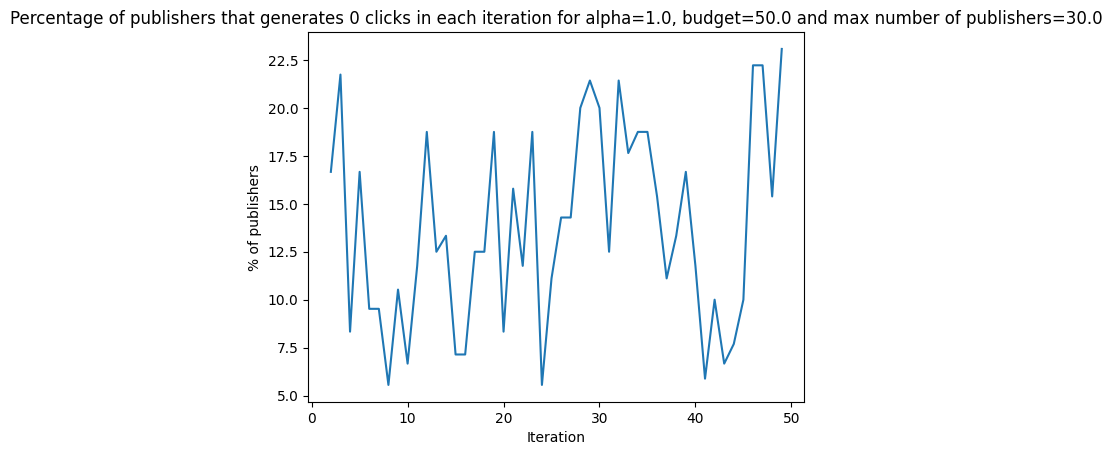

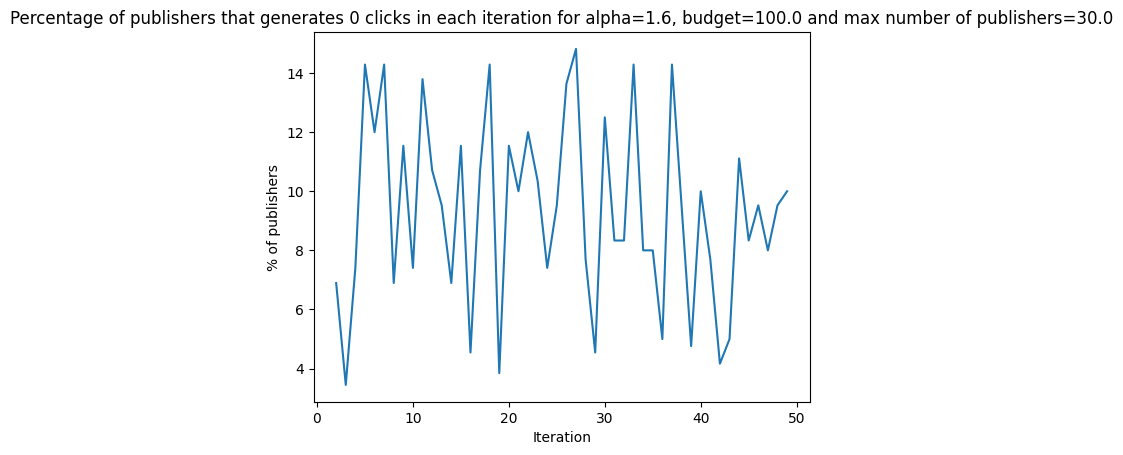

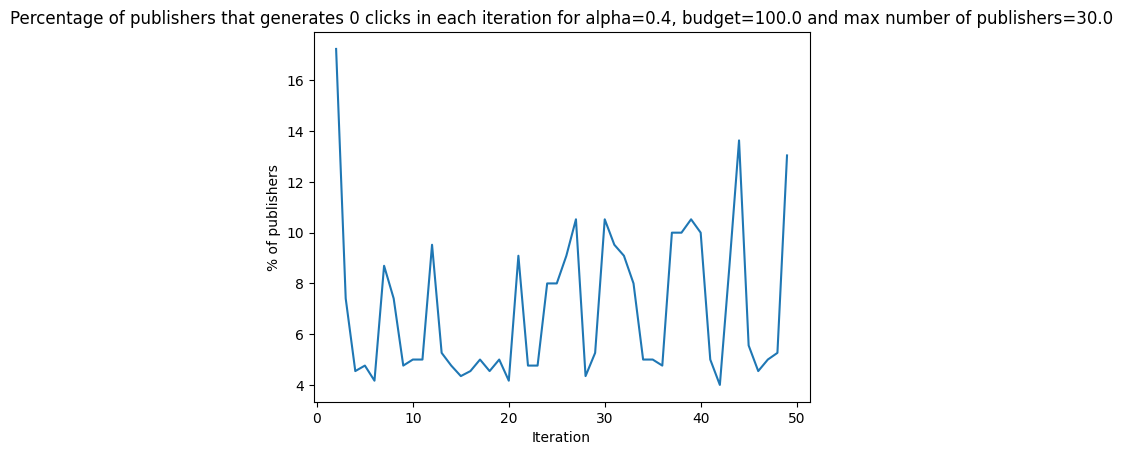

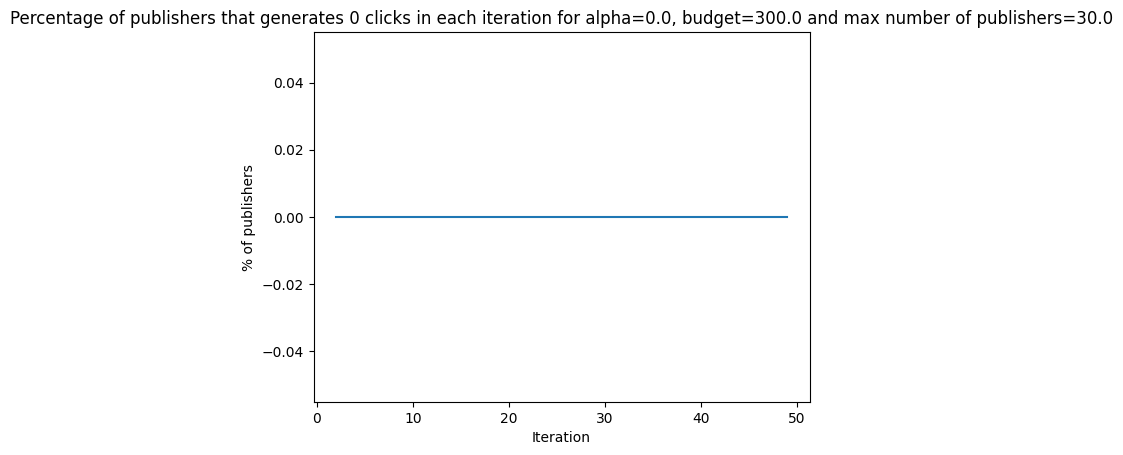

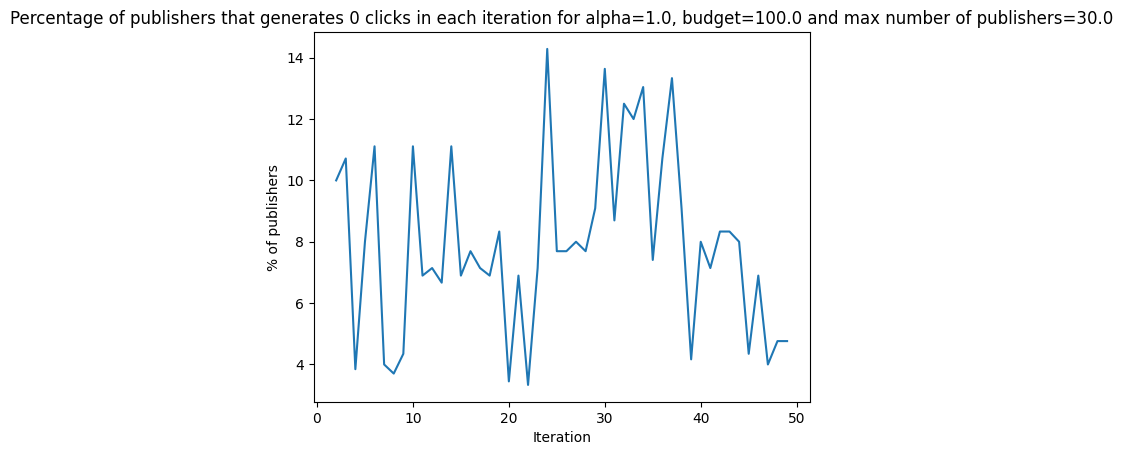

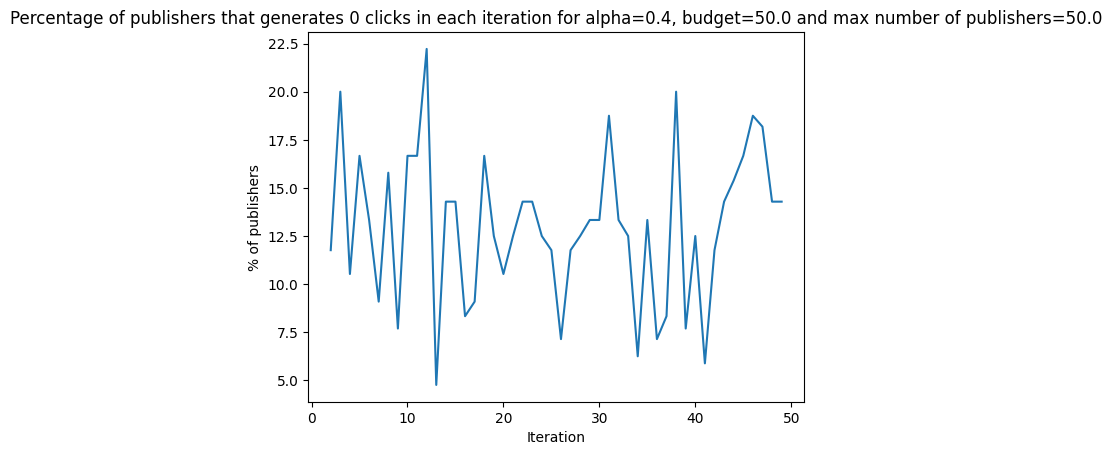

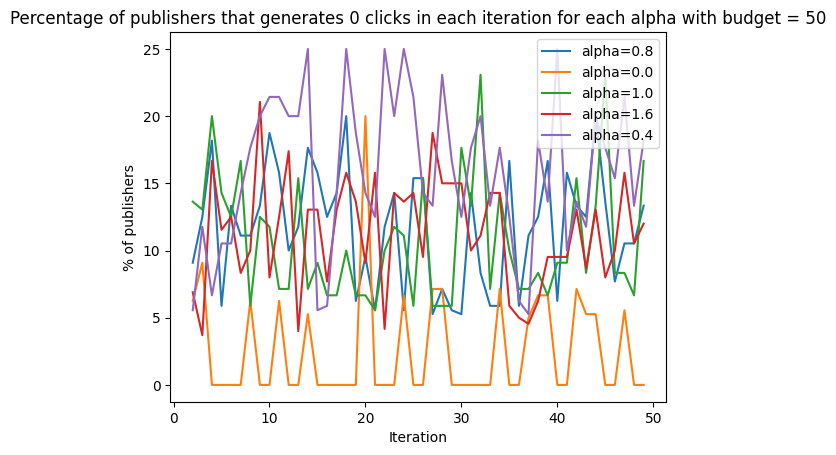

In [30]:
for alpha, lin_ucb_params in results.items():
    all_iterations = lin_ucb_params['Iteration'].unique()
    zero_clicks = lin_ucb_params[(lin_ucb_params['Iteration'] > 1) & (lin_ucb_params['clicks'] == 0)] \
        .groupby('Iteration').size().reset_index(name='count') \
        .set_index('Iteration').reindex(all_iterations, fill_value=0)
    total = lin_ucb_params[(lin_ucb_params['Iteration'] > 1)] \
        .groupby('Iteration').size().reset_index(name='count') \
        .set_index('Iteration').reindex(all_iterations, fill_value=0)
    perc_zero_clicks = (zero_clicks['count'] / total['count']) * 100
    perc_zero_clicks = perc_zero_clicks.sort_index()
    perc_zero_clicks.plot(label=f'alpha={alpha}')
    plt.title(f"Percentage of publishers that generates 0 clicks in each iteration for each alpha with budget = {budget}")
    plt.xlabel('Iteration')
    plt.ylabel('% of publishers')
    plt.legend()

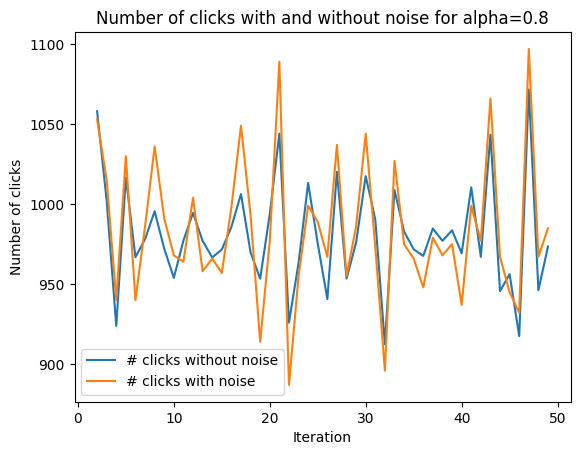

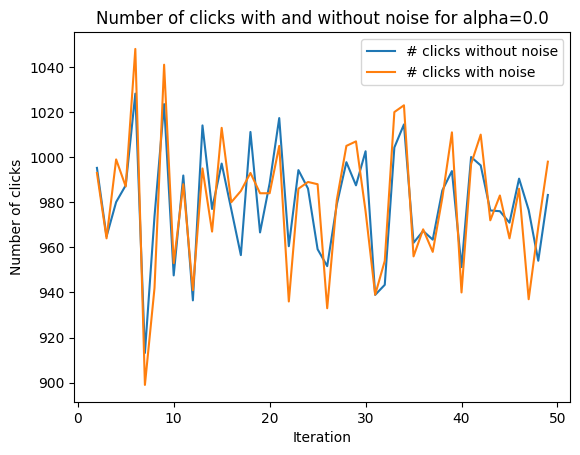

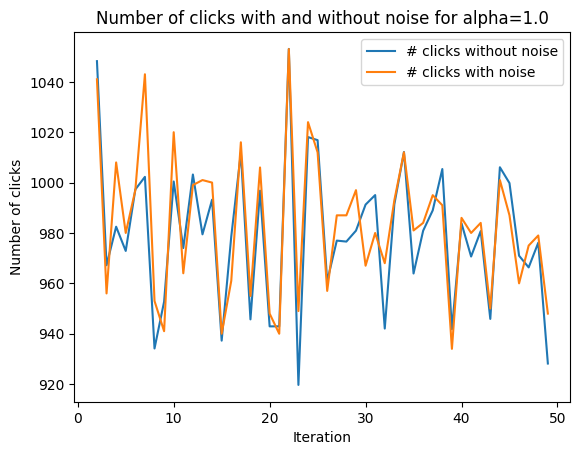

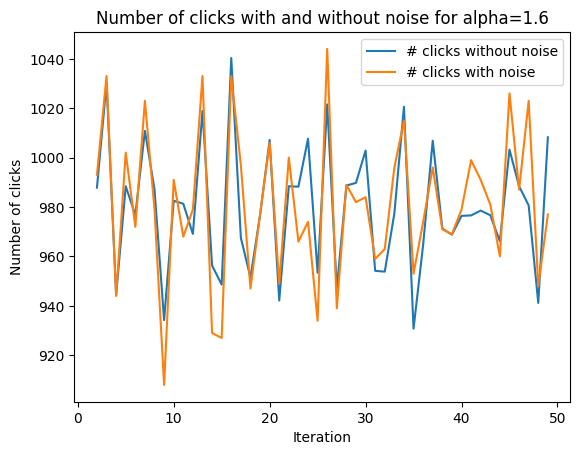

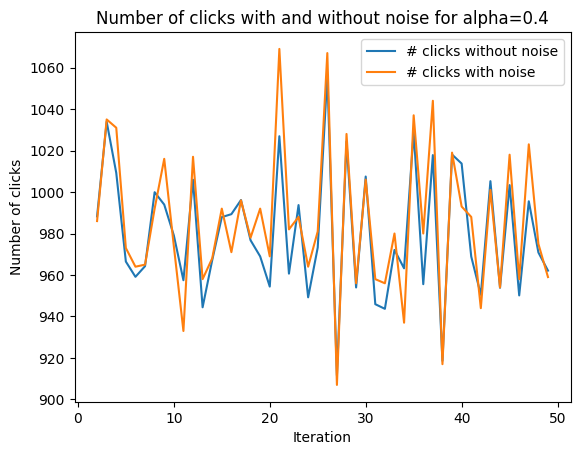

In [40]:
# Plot number of clicks without noise for each alpha with a separate plot
grouped_results = {}
for alpha, lin_ucb_params in results.items():
    grouped_results[alpha] = lin_ucb_params[lin_ucb_params['Iteration']>1].groupby('Iteration').agg({'clicks': 'sum', 'true_clicks': 'sum'})
for alpha, a_g_res in grouped_results.items():
    plt.title(f'Number of clicks with and without noise for alpha={alpha}')
    plt.plot(a_g_res.index.to_numpy(), a_g_res['true_clicks'].to_numpy(), label=f'# clicks without noise')
    plt.plot(a_g_res.index.to_numpy(), a_g_res['clicks'].to_numpy(), label=f'# clicks with noise')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks')
    plt.legend()
    plt.show()

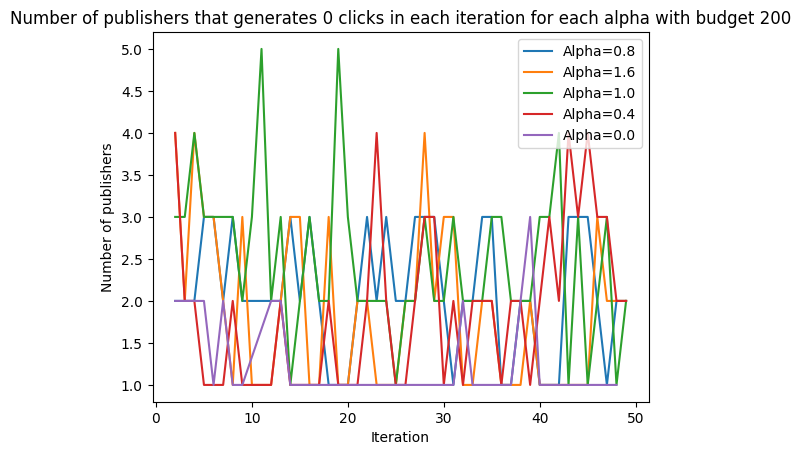

In [17]:
for alpha, lin_ucb_params in results.items():
    lin_ucb_params[(lin_ucb_params['Iteration'] > 1) & (lin_ucb_params['clicks'] == 0)].groupby('Iteration').size().plot(label=f'Alpha={alpha}')
    plt.title(f"Number of publishers that generates 0 clicks in each iteration for each alpha with budget {budget}")
    plt.xlabel('Iteration')
    plt.ylabel('Number of publishers')
    plt.legend()

In [34]:
def plot_perc_zero_pub(budget, save_dir):
    files_to_read = [file for file in os.listdir(save_dir) if file.startswith(f'agent_stats_budget_{budget}_')]
    results = {}
    for file in files_to_read:
        lin_ucb_params = pd.read_csv(f'{save_dir}{file}')
        results[float(file.split("_")[-1].split(".csv")[0])] = lin_ucb_params
    for alpha, lin_ucb_params in results.items():
        all_iterations = lin_ucb_params['Iteration'].unique()
        zero_clicks = lin_ucb_params[(lin_ucb_params['Iteration'] > 1) & (lin_ucb_params['clicks'] == 0)] \
            .groupby('Iteration').size().reset_index(name='count') \
            .set_index('Iteration').reindex(all_iterations, fill_value=0)
        total = lin_ucb_params[(lin_ucb_params['Iteration'] > 1)] \
            .groupby('Iteration').size().reset_index(name='count') \
            .set_index('Iteration').reindex(all_iterations, fill_value=0)
        perc_zero_clicks = (zero_clicks['count'] / total['count']) * 100
        perc_zero_clicks = perc_zero_clicks.sort_index()
        perc_zero_clicks.plot(label=f'alpha={alpha}')
        plt.title(f"Percentage of publishers that generates 0 clicks in each\n iteration for each alpha with budget = {budget}")
        plt.xlabel('Iteration')
        plt.ylabel('% of publishers')
        plt.legend()
        plt.tight_layout()
    plt.savefig(f'{save_dir}perc_zero_pub_budget_{budget}.png')
    plt.close()

In [35]:
for budget in [50, 100, 150, 200, 300]:
    plot_perc_zero_pub(budget, save_dir)

In [40]:
np.exp(-0.1*200)

2.061153622438558e-09

In [42]:
prova = results[1]
prova = prova[(prova['Iteration'] > 1)]

In [45]:
prova.groupby('Iteration').agg({'spent': 'sum', 'p': 'sum', 'num_clicks': 'sum'})

spent            p  num_clicks
Iteration                                    
2          72.916984   690.522248      1382.0
3          65.525456   700.959951      1317.0
4          55.043635   688.614260      1098.0
5          52.784560   741.229796      1074.0
6          57.739566   792.895013      1159.0
...              ...          ...         ...
95         52.423672   992.493768      1013.0
96         44.774241   958.324774       852.0
97         54.633031  1031.831997      1066.0
98         53.070600   962.148663      1065.0
99         48.666226   922.966303       925.0

[98 rows x 3 columns]

In [48]:
prova[prova['num_clicks'] != 0].groupby('Iteration').agg({'spent': 'sum', 'p': 'sum'})

spent            p
Iteration                        
2          72.816327   629.338716
3          65.525456   656.087973
4          55.043635   640.321972
5          52.784560   710.544074
6          57.739566   759.130971
...              ...          ...
95         52.423672   985.954109
96         44.774241   951.817965
97         54.633031  1018.922446
98         53.070600   951.337458
99         48.666226   916.555150

[98 rows x 2 columns]

In [59]:
prova[prova['num_clicks'] != 0].groupby('Iteration').agg({'p': 'mean'})

p
Iteration           
2          13.390185
3          17.265473
4          20.655547
5          22.204502
6          24.488096
...              ...
95         46.950196
96         47.590898
97         42.455102
98         41.362498
99         43.645483

[98 rows x 1 columns]

In [60]:
prova[prova['num_clicks'] == 0].groupby('Iteration').agg({'p': 'mean', 'spent': 'mean'})

p     spent
Iteration                    
2          0.588303  0.000968
3          0.472337  0.000000
4          0.530684  0.000000
5          0.352709  0.000000
6          0.379371  0.000000
...             ...       ...
95         0.100610  0.000000
96         0.100105  0.000000
97         0.195599  0.000000
98         0.163806  0.000000
99         0.098633  0.000000

[98 rows x 2 columns]

In [57]:
prova[prova['num_clicks'] == 0].groupby('Iteration').agg({'spent': 'sum', 'p': 'sum', 'publisher': 'size'})

spent          p  publisher
Iteration                                
2          0.100657  61.183532        104
3          0.000000  44.871978         95
4          0.000000  48.292288         91
5          0.000000  30.685722         87
6          0.000000  33.764042         89
...             ...        ...        ...
95         0.000000   6.539659         65
96         0.000000   6.506809         65
97         0.000000  12.909551         66
98         0.000000  10.811205         66
99         0.000000   6.411152         65

[98 rows x 3 columns]

In [49]:
prova[prova['num_clicks'] == 0]

publisher  won_auctions  lost_auctions  win_rate  \
108               accordiespartiti.it             0            297       0.0   
109               accordiespartiti.it             0            275       0.0   
110               accordiespartiti.it             0            294       0.0   
111               accordiespartiti.it             0            287       0.0   
112               accordiespartiti.it             0            257       0.0   
...                               ...           ...            ...       ...   
9647                         vogue.es             0            286       0.0   
9648                         vogue.es             0            279       0.0   
9649                         vogue.es             0            280       0.0   
9850  www-hola-com.cdn.ampproject.org             0            288       0.0   
9854  www-hola-com.cdn.ampproject.org             0            272       0.0   

      num_clicks  ctr  true_ctr  spent  mean_bid  cpc  cpm     Agent  \
108          0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
109          0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
110          0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
111          0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
112          0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
...          ...  ...       ...    ...       ...  ...  ...       ...   
9647         0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
9648         0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
9649         0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
9850         0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   
9854         0.0  0.0       0.0    0.0       0.0  0.0  0.0  Nostro 1   

      Iteration   exp_rew         p  num_clicks_no_noise  
108           2  0.000000  0.433826                  0.0  
109           3  0.000000  0.397988                  0.0  
110           4  0.000000  0.369778                  0.0  
111           5  0.000000  0.346826                  0.0  
112           6  0.000000  0.327678                  0.0  
...         ...       ...       ...                  ...  
9647         97  0.000000  0.099664                  0.0  
9648         98  0.000000  0.099173                  0.0  
9649         99  0.000000  0.098689                  0.0  
9850          2  2.194393  2.576875                  0.0  
9854         69  3.414669  3.718459                  0.0  

[6991 rows x 16 columns]

In [63]:
prova['new_spent'] = prova.apply(lambda x: np.exp(-0.1 * x['p']) if x['spent'] == 0 else x['spent'], axis=1)

/var/folders/pt/p9_0myf16lx1rjjrf63vkx5w0000gp/T/ipykernel_92178/319234781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prova['new_spent'] = prova.apply(lambda x: np.exp(-0.1 * x['p']) if x['spent'] == 0 else x['spent'], axis=1)
